# CS 583 Lecture 12 

### One more look at synthesis: summarizing spectra, wavetables, and resampling real signals

In this lecture we will explore two different ways of creating realistic musical notes through two techniques:

1.  Summarizing spectra of real instrument samples using "peak picking" to emphasize *tonal components* of the spectra; and

2. Creating a wavetable from a real signal and using interpolation to resample to create arbitrary frequencies.

 

### Utility Code

In [1]:
# General useful imports
import numpy as np
import matplotlib.pyplot as plt
import librosa 
import librosa.display
from IPython.display import Audio

from scipy import signal

%matplotlib inline

# Basic audio parameters

SR            = 22050                  #  sample rate default for Librosa

# Utility functions

# Round to 4 decimal places

def round4(x):
    return np.around(x,4)   

path = "https://www.cs.bu.edu/fac/snyder/cs583/AudioSamples/"    

### Creating Audio Signals

In [2]:
def makeSignal(S=[(440,1,0)], A = None, duration=1.0,sr=SR):
    X = np.zeros(int(sr*duration)) 
    T = np.arange(int(sr*duration))
    for (f,amp,phi) in S:         
        X +=  amp * np.sin( 2 * np.pi * f * T / sr + phi )
    X / max(X)         # normalize to amplitude 1.0
    if(A == None):
        return  X       
    else:
        return  A * X    

In [3]:
# create a dictionary of piano key frequencies

# see https://en.wikipedia.org/wiki/Piano_key_frequencies

notenames = ['A0', 'Bb0', 'B0', 'C1', 'C#1', 'D1', 'Eb1', 'E1', 'F1', 'F#1',
       'G1', 'Ab1', 'A1', 'Bb1', 'B1', 'C2', 'C#2', 'D2', 'Eb2', 'E2',
       'F2', 'F#2', 'G2', 'Ab2', 'A2', 'Bb2', 'B2', 'C3', 'C#3', 'D3',
       'Eb3', 'E3', 'F3', 'F#3', 'G3', 'Ab3', 'A3', 'Bb3', 'B3', 'C4',
       'C#4', 'D4', 'Eb4', 'E4', 'F4', 'F#4', 'G4', 'Ab4', 'A4', 'Bb4',
       'B4', 'C5', 'C#5', 'D5', 'Eb5', 'E5', 'F5', 'F#5', 'G5', 'Ab5',
       'A5', 'Bb5', 'B5', 'C6', 'C#6', 'D6', 'Eb6', 'E6', 'F6', 'F#6',
       'G6', 'Ab6', 'A6', 'Bb6', 'B6', 'C7', 'C#7', 'D7', 'Eb7', 'E7',
       'F7', 'F#7', 'G7', 'Ab7', 'A7', 'Bb7', 'B7', 'C8', 'R']

# Create chromatic scale, e.g., as on the piano, as a dictionary    

Freqs = {} 

f = 27.5

for name in notenames:
    Freqs[name] = f
    f *= 2**(1/12)

Freqs['R'] = 0                    # a rest (silence) 

# test

Freqs['C8']

4186.009044809592

In [4]:
# get signal array and sample rate from a local audio file, will resample to default SR of 22050

import soundfile as sf
import io
import warnings

from six.moves.urllib.request import urlopen

def readSignal(name,sr=SR):    
    if(name[:5] == 'https'):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            X, fileSR = sf.read(io.BytesIO(urlopen(name).read()))           
    else:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            X, fileSR = librosa.load(name)
    if(fileSR == sr):
        return X
    else:
        return librosa.resample(X,fileSR,SR) 

# write signal array out to a file in your local directory (or to complete path name)

def writeSignal(name,data,sr=SR):
    sf.write(name,data,sr)

### Two functions for displaying waveforms

In [5]:
# Display 


def displaySignal(X, sr=SR, title='Signal Window for X',x_units = "Seconds", figsize=(14,6),gridlines=False): 
    
    if(x_units == "Seconds"):
        T = np.arange(0, len(X)/sr, 1/sr)
    elif(x_units == "Milliseconds"):
        T = np.arange(0, 1000*len(X)/sr, 1000/sr)
    elif(x_units == "Samples"):
        T = np.arange(len(X))

    plt.figure(figsize=figsize)   # Set x and y dimensions of window: may need to redo for your display
    plt.title(title, fontsize=14, fontweight='bold')
    if(x_units=="Samples"):
        plt.xlabel("Sample Number")
    else:
        plt.xlabel(x_units)
    plt.ylabel("Amplitude")
    plt.ylim([-1.1,1.1])
    plt.plot([0,T[-1]],[0,0],color='black')      # draw the 0 line in black
    plt.plot(T,X)                    
    plt.grid(gridlines)                     # if you want dotted grid lines
    plt.show()
    
# test

# f = 10
# X = makeSignal([(10,1,0)])
# displaySignal(X,gridlines=True)

# displaySignal(X,x_units="Samples")

# displaySignal(X,x_units="Milliseconds")


In [6]:
# display the waveform

def displaySignal2(x,sr=SR,title='Signal X',):
    plt.figure(figsize=(12,6))
    plt.title(title)
    plt.ylim([-1.1,1.1])           # if you want the full range -1 .. 1, else will adapt to signal
    plt.plot([0,librosa.get_duration(x)],[0,0],linewidth=1,color='k') # if you want a 0 line
    #plt.grid()                    # if you want gridlines
    librosa.display.waveshow(x,sr=sr)
    plt.show()
    
# X = readSignal(k + "trumpet_A4_1_forte_normal.wav")

# displaySignal(X)

### Fast Fourier Transform

The following returns the real spectrum of a signal (amplitude only, no phase) as an array of floats of length $\lfloor N/2\rfloor + 1$ for frequencies 0, f, 2f, ..., up to the Nyquist limit (half the sample rate). 

In [7]:
def realFFT(X):
    return 2*abs(np.fft.rfft(X))/len(X) 

# test

# X = makeSignal(S=[(220,0.5,0),(440,0.3,0),(880,0.2,0),(1100,0.1,0),],duration = 0.19)

# S = realFFT(X)

# print("window frequency", round4(1/0.19))

# print("220 =",220/(1/0.19), "*", round4(1/0.19))
# print()

# for i in range(35,50):
#     print("S["+str(i)+"]:",S[i])

# plt.figure(figsize=(12,6))
# plt.plot(S)
# plt.show()

In [8]:
# We can also return a list of triples of form  [f, A, phi] for each frequency
# f detected by the transform, however, note that, due to floating-point error, 
# you will get extremely small values instead of 0.0 for most of the frequencies; 
# therefore allow the option of filtering out these values using np.isclose(...)
    
def spectrumFFT(X,filterZeros=True):
    R =  np.fft.rfft(X)
    if(filterZeros):
        return np.array([ ( k*SR/len(X), 2.0 * np.absolute(R[k])/len(X),np.angle(R[k])+(np.pi/2) ) 
                            for k in range(len(R)) 
                                if not np.isclose(2.0 * np.absolute(R[k])/len(X),0.0) ]) 
    else:
        return np.array([ ( k*SR/len(X), 2.0 * np.absolute(R[k])/len(X),np.angle(R[k])+(np.pi/2) ) 
                            for k in range(len(R)) ]) 

# test
    
# T = np.arange(SR*0.1)    # duration = 0.1 sec
# SR = 22050
# X = 10000 * np.sin( 2 * np.pi * 1000 * T / SR )
# X += 5000 * np.sin( 2 * np.pi * 3000 * T / SR )
# X += 2500 * np.sin( 2 * np.pi * 5000 * T / SR )

# print(round4(spectrumFFT(X)))
# print()
# S = spectrumFFT(X,False)
# print(round4(S[:5]))
# print()
# print(round4(S[98:104]))
# print()
# print(round4(S[-5:]))

### Inverse FFT

In [9]:
# To create a signal of N samples, must input a spectrum array
# of length N/2 + 1 amplitudes, with the kth frequency bin
# representing the amplitude of frequency k*(SR/N)

def realIFFT(S,A=None):
    S = np.array(S)
    lenX = 2*(len(S)-1)
    complex_S = lenX / 2 * -1.j * S
    X = np.fft.irfft(complex_S)
    if(A == None):
        return X
    else:
        return A * X / max(X)

# test

# S = np.zeros(22050)
# S[220] = 1.0
# S[440] = 0.5
# S[880] = 0.25
# S[1760] = 0.125
# X = realIFFT(S)
# plt.plot(X[:1000])
# plt.show()

# Audio(X,rate=SR)

###  Displaying Instantaneous Spectra

Matplotlib has a useful function to display a spectrum for the whole signal; by giving it
a short "window" you can get the same information contained in one column of the spectrogram:

https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.magnitude_spectrum.html

The term "magnitude spectrum" refers to the fact that we are interested in magnitude
of the various frequencies which make up the signal, instead of the power spectrum (square of the magnitudes) or the phase spectrum (what the phase of the various frequency components are). 


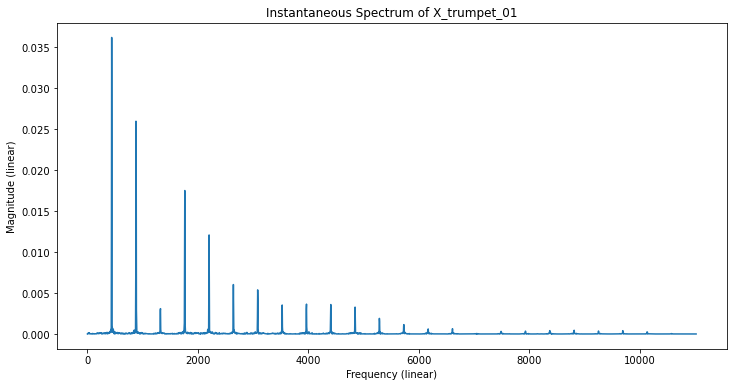

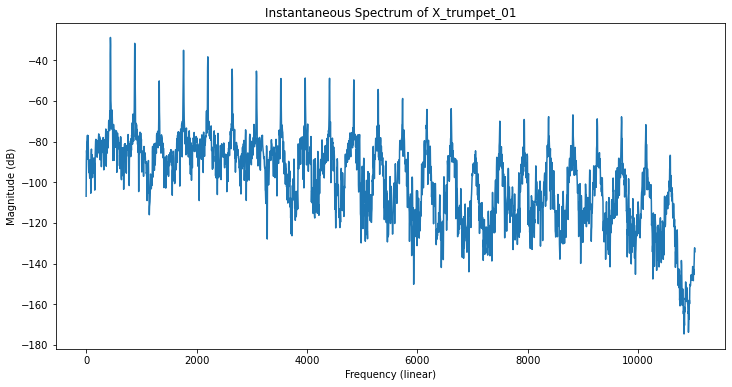

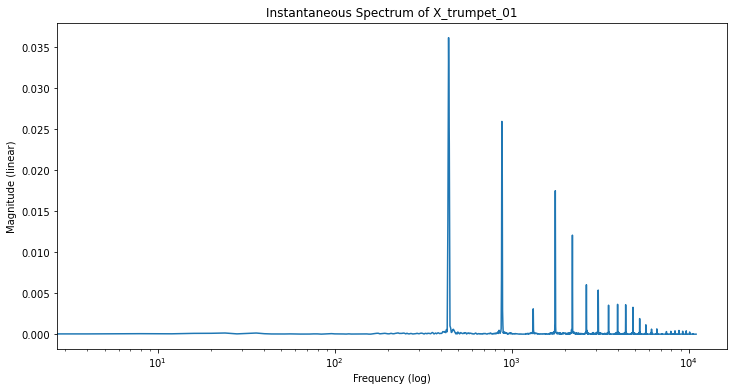

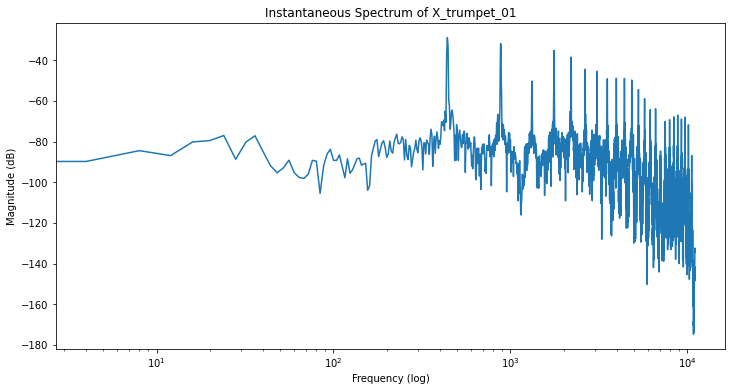

In [10]:
# display the spectrum:   xscale (frequency) can be 'linear' or 'log',
#     and yscale can be 'linear' or 'dB' (essentially log)

def displaySpectrum(X,sr=SR,title='Spectrum of X',xscale='linear',yscale='dB'):
    plt.figure(figsize=(12,6))
    plt.title(title)
    plt.magnitude_spectrum(X,sr,scale=yscale)
    if(xscale == 'linear'):
        plt.xlabel('Frequency (linear)')
    else:    
        plt.xlabel('Frequency (log)')
    if(yscale == 'linear'):
        plt.ylabel('Magnitude (linear)')
    else:    
        plt.ylabel('Magnitude (dB)')
    plt.xscale(xscale)
    plt.show()
    
    
# Example: Create a signal with a simple spectrum

X_trumpet = readSignal(path + "trumpet_A4_1_forte_normal.wav")

# displaySignal(X,title="Signal X: Trumpet playing note A4 = 440 Hz")

X_trumpet_01 = X_trumpet[11025:16537]

# displaySignal(X1,title="Signal X1:  Signal X from 0.5 - 0.75 secs")

# # display the spectrum   scale is 'linear' or 'dB'
    
displaySpectrum(X_trumpet_01,title="Instantaneous Spectrum of X_trumpet_01", xscale='linear', yscale='linear')

displaySpectrum(X_trumpet_01,title="Instantaneous Spectrum of X_trumpet_01",xscale='linear', yscale='dB')

displaySpectrum(X_trumpet_01,title="Instantaneous Spectrum of X_trumpet_01",xscale='log', yscale='linear')

displaySpectrum(X_trumpet_01,title="Instantaneous Spectrum of X_trumpet_01",xscale='log', yscale='dB')

### Displaying Spectrograms

We can use `librosa.display.specshow` to show spectrograms, which are heatmaps of
spectra over top. Various parameters can be set, including:

    y_axis :   'linear', 'log', 'mel'

    fmin, fmax :  frequency bounds for the mel frequency spectrogram; defaults are fmin=0 and fmax=SR/2 (Nyquist limit)
    
In addition, the `librosa.stft` function takes parameters

    n_fft :    length of the analysis window in samples; defaults to 2048
    
    hop_length : how many samples the window is moved forward for every spectrum; defaults to n_fft / 4

The following is produces a linear scale on the frequency (Y) axis; notice that the typical linear spacing of harmonics (f, 2f, 3f, 4f, etc.) is shown clearly, and correspond to the instantaneous spectrum with a linear frequency scale shown above. 

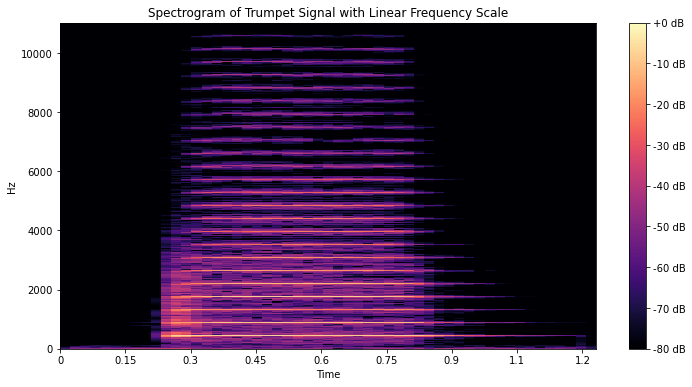

In [11]:
# display the spectrogram

S = np.abs(librosa.stft(X_trumpet))                    # calculate the 2D spectrogram
Sdb = librosa.amplitude_to_db(S, ref=np.max)   # will show power spectrum in heatmap

plt.figure(figsize=(12,6))
plt.title("Spectrogram of Trumpet Signal with Linear Frequency Scale")
librosa.display.specshow(Sdb, sr=SR, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.show()

Now we change the frequency scale to a log scale, and we can see that the linear sequence of harmonics gets closer and closer together, just as they do on the log scale spectrum above, and, in fact, on a piano keyboard. 

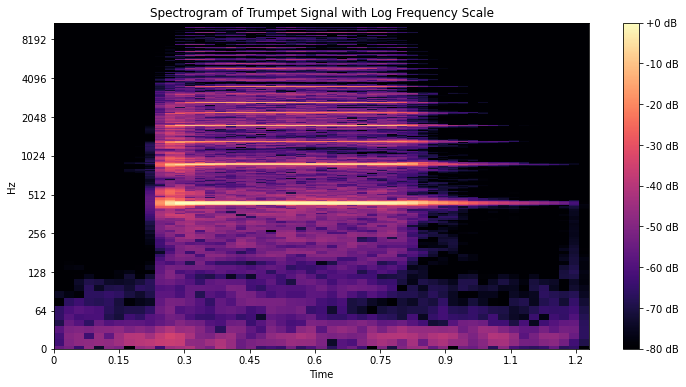

In [12]:
S = np.abs(librosa.stft(X_trumpet))                    # calculate the 2D spectrogram
Sdb = librosa.amplitude_to_db(S, ref=np.max)   # will show power spectrum in heatmap

plt.figure(figsize=(12,6))
plt.title("Spectrogram of Trumpet Signal with Log Frequency Scale")
librosa.display.specshow(Sdb, sr=SR, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.show()

### Filterbanks, Mel Scale, Spectrum, and Spectrogram

We can think of the FFT as a sequence of *filters* that isolate the energy in certain frequency bands,
according to the sequence of frequencies 0, f, 2f, etc. up to the Nyquist Limit.  The general approach is often called a *filter bank*, and algorithms can be written that determine the energy at frequencies in different bands than the FFT.

One of the most common approaches (other than the FFT) in Music Information Retrieval uses a sequence of frequency bands that correspond more closely to the logarithmic scale of frequencies in Western music notation and the piano keyboard. 

The Mel Scale is based on research from almost a century ago that pitch (human perception of the frequency of a tone) is not the same as the
frequency as determined by physical measurements or by an algorithm. 

This is a modification of the log scale, according to the following formula:

$$m\ =\ 2595\cdot \text{log}_{10}\bigl ( 1 + {f\over 700} \bigr )$$

and can be graphed as follows:

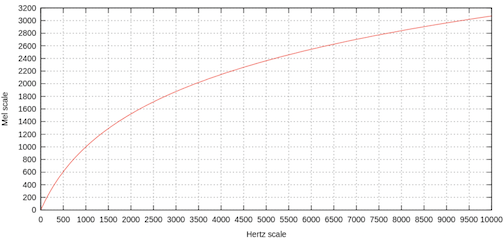

A *mel scale* is used to give a closer approximation to human perception of musical pitch, just as the power spectrum is used to give a closer approximation to loudness. Neither is perfectly accurate, as many, many factors influence the psycho-acoustic perception of musical signals, but they are the best possible approximations (at present). 

The range of the mel scale can be set with `fmin` (defaults to 0) to `fmax` (defaults to SR/2, the Nyquist limit), but can be set lower. 

The parameter `n_mels` (defaulting to 128) gives the number of frequency bins in this range, according to the mel scale. 



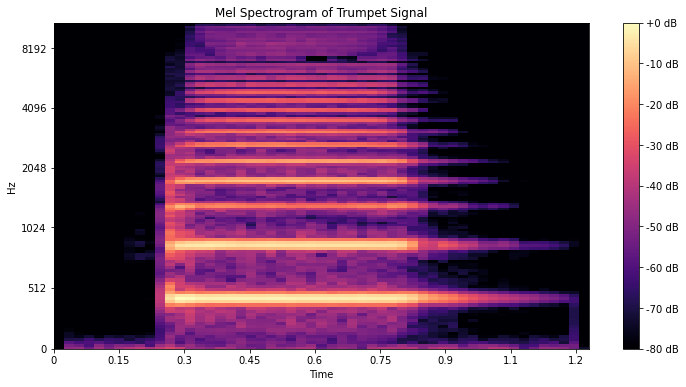

In [13]:
mel_spect = librosa.feature.melspectrogram(y=X_trumpet, sr=SR, n_fft=1024, hop_length=512)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)

plt.figure(figsize=(12,6))
librosa.display.specshow(mel_spect, y_axis='mel',  x_axis='time');
plt.title('Mel Spectrogram of Trumpet Signal');
plt.colorbar(format='%+2.0f dB');

Notice in the next spectrogram that the maximum frequency has been set to 4200 (approximately the highest frequency on the piano keyboard) and there are only 64 mel frequency bands. 

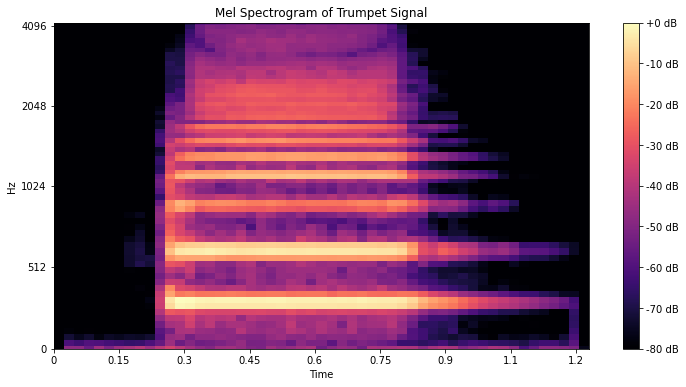

In [14]:
mel_spect = librosa.feature.melspectrogram(y=X_trumpet, sr=SR, n_fft=1024, hop_length=512,n_mels=64)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)

plt.figure(figsize=(12,6))
librosa.display.specshow(mel_spect, y_axis='mel', fmax=4200, x_axis='time');
plt.title('Mel Spectrogram of Trumpet Signal');
plt.colorbar(format='%+2.0f dB');

### Ok, on to new material....

# Summarizing spectra using peak picking

Spectra consist of (at least) the following components:

1. Tonal components that represent the frequency and timbre of a musical signal;
2. Timing information (mostly represented in the phase, which we generally ignore in displaying spectra); and
3. Noise due to audio processing (e.g., floating-point error) and perhaps actual background noise. 

Try the trumpet sound first....

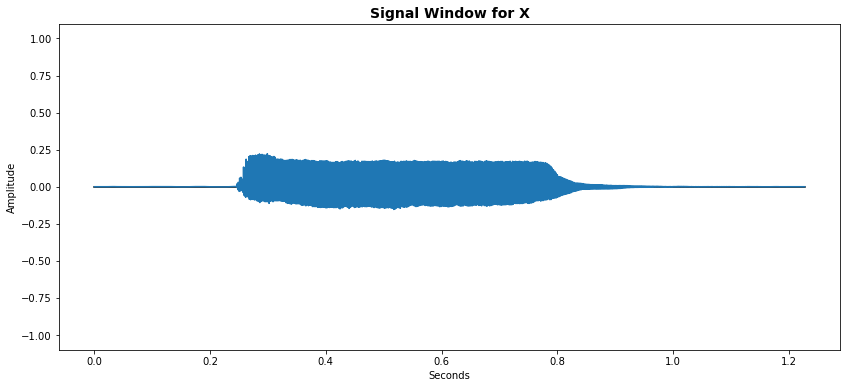

In [15]:
X_clarinet = readSignal('https://www.cs.bu.edu/fac/snyder/cs583/AudioSamples/realClarinet440.wav')
X_oboe = readSignal('https://www.cs.bu.edu/fac/snyder/cs583/AudioSamples/oboe_A4_1_mezzo-forte_normal.wav')
X_guitar = readSignal('https://www.cs.bu.edu/fac/snyder/cs583/AudioSamples/flute_A4_1_mezzo-forte_normal.wav')
X_trumpet = readSignal('https://www.cs.bu.edu/fac/snyder/cs583/AudioSamples/trumpet_A4_1_forte_normal.wav')

displaySignal(X_trumpet)

Audio(X_trumpet,rate=SR)

Our objective is to identify the tonal components of the signal, so we will first extract a *sample* (a window) which has as little variation in tone color and amplitude as possible. 

In general, the longer the sample the better (since then you will have better frequency resolution) and you will get better accuracy if the length of your sample is a power of 2, but this is not absolutely necessary. 

start:  8192 	end:  16384 	(in samples)
start:  0.3715 	end:  0.743 	(in seconds)
len(X1): 8192
total secs: 0.3715
frequency resolution:  2.6917 Hz


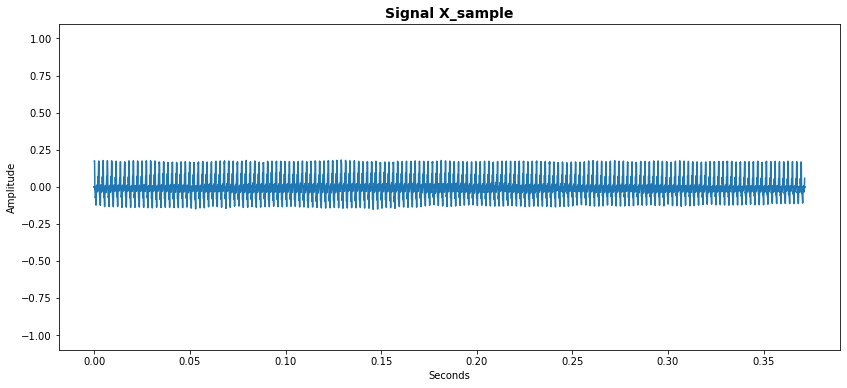

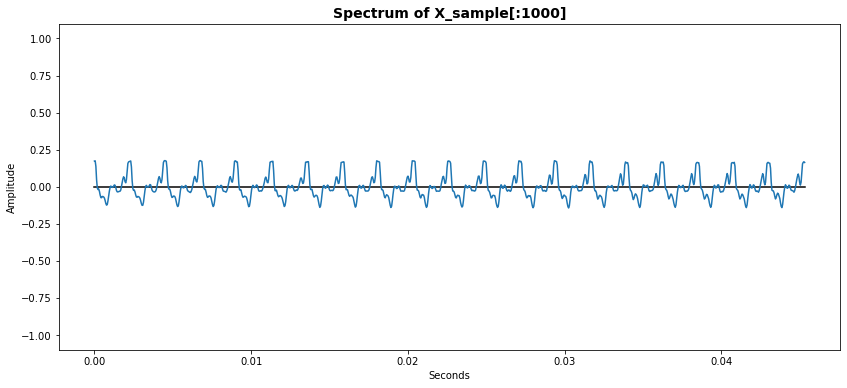

In [16]:
X = X_trumpet

# extract a suitable sample
start = 2**13
end = 2**14
X_sample = X[start:end]

print('start: ',start, '\tend: ',end, '\t(in samples)')
print('start: ',round4(start/SR), '\tend: ', 
      round4(end/SR), '\t(in seconds)')

print("len(X1):", len(X_sample))
print("total secs:", round4(len(X_sample)/SR))
print("frequency resolution: ",round4(SR/len(X_sample)),"Hz")

window_freq = SR/len(X_sample)

displaySignal(X_sample,title='Signal X_sample')

displaySignal(X_sample[:1000],title='Spectrum of X_sample[:1000]')

Audio(X_sample,rate=SR)

Let's display the spectrum, and observe the regular peaks

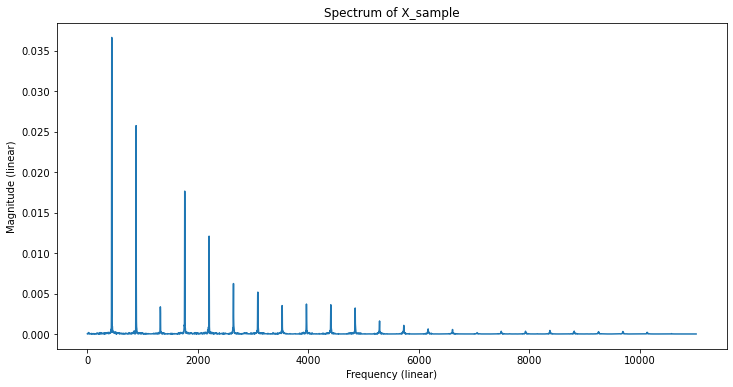

In [17]:
# display the spectrum:   xscale (frequency) can be 'linear' or 'log',
#     and yscale can be 'linear' or 'dB' (essentially log)

displaySpectrum(X_sample,sr=SR,title='Spectrum of X_sample',
                xscale='linear',yscale='linear')

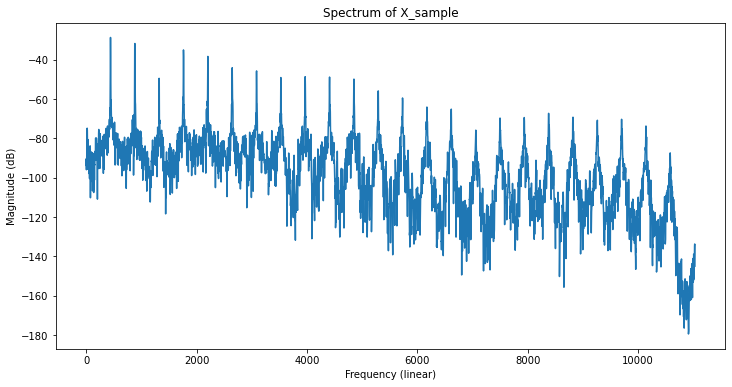

In [18]:
displaySpectrum(X_sample,title='Spectrum of X_sample')

Although spectrograms are usually applied to whole signals, not short windows (because they display timing information), it is interesting to look at the spectrogram of the sample.

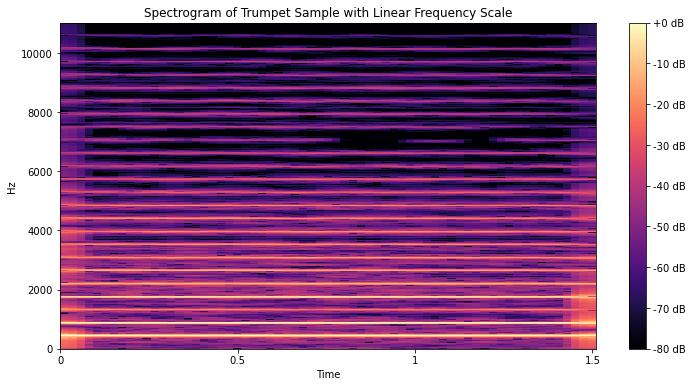

In [19]:
S = np.abs(librosa.stft(X_sample,n_fft=1024,hop_length=128))                    # calculate the 2D spectrogram
Sdb = librosa.amplitude_to_db(S, ref=np.max)   # will show power spectrum in heatmap

plt.figure(figsize=(12,6))
plt.title("Spectrogram of Trumpet Sample with Linear Frequency Scale")
librosa.display.specshow(Sdb, sr=SR, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.show()

To actually generate the spectrum we will use realFFT and take the log of the spectrum to see a more useful display of the spectral energies (this was done in the spectrogram above by the function `librosa.amplitude_to_db`). 

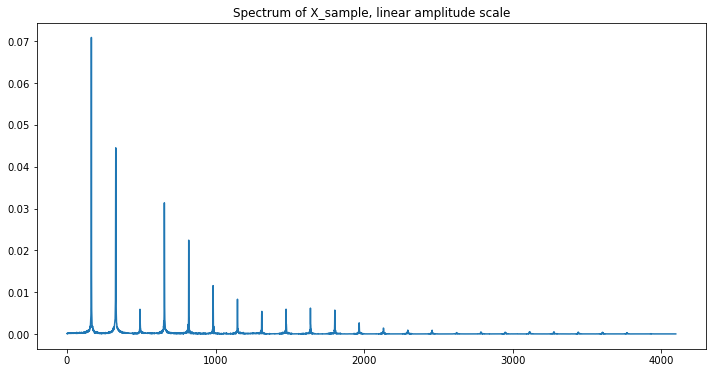

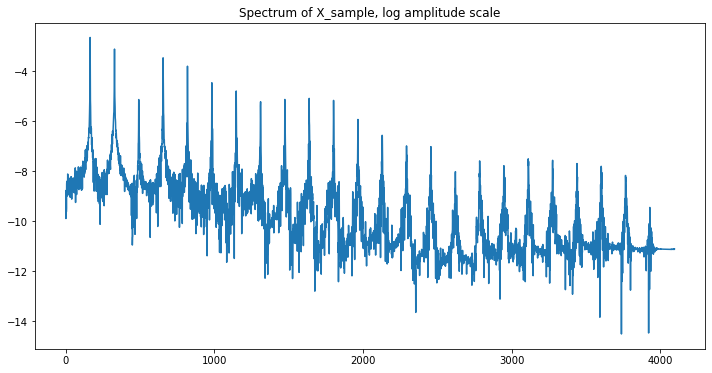

In [20]:
S = realFFT(X_sample)
logS = np.log(S)

plt.figure(figsize=(12,6))
plt.title("Spectrum of X_sample, linear amplitude scale")
plt.plot(S)
plt.show()

# print(S)

plt.figure(figsize=(12,6))
plt.title("Spectrum of X_sample, log amplitude scale")
plt.plot(logS)
plt.show()


Now let's find the peaks in the spectrum...


**Our peak-finding algorithm in HW 02 is a good first approximation, but does not work with spectra because of the roll-off of amplitudes, so we can't use a fixed threshold.**

There are several choices for libraries that contain peak-finding functions, I prefer `scipy.signal.find_peaks` to `librosa.util.peak_pick` (more on this below). 

Finding peaks with very different heights is generally difficult, and the algorithms don't work very well with linear spectra:

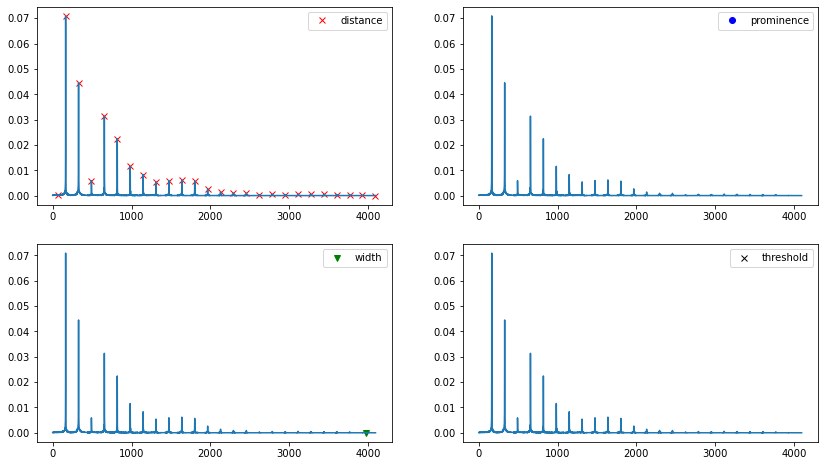

In [21]:
from scipy.signal import find_peaks

x = S
peaks, _ = find_peaks(x, distance=100)            
peaks2, _ = find_peaks(x, prominence=4)      # BEST!  
peaks3, _ = find_peaks(x, width=20)
peaks4, _ = find_peaks(x, threshold=0.4)     # Required vertical distance to its direct neighbouring samples, pretty useless

plt.figure(figsize=(14,8))
plt.subplot(2, 2, 1)
plt.plot(peaks, x[peaks], "xr"); plt.plot(x); plt.legend(['distance'])
plt.subplot(2, 2, 2)
plt.plot(peaks2, x[peaks2], "ob"); plt.plot(x); plt.legend(['prominence'])
plt.subplot(2, 2, 3)
plt.plot(peaks3, x[peaks3], "vg"); plt.plot(x); plt.legend(['width'])
plt.subplot(2, 2, 4)
plt.plot(peaks4, x[peaks4], "xk"); plt.plot(x); plt.legend(['threshold'])
plt.show()

So let's use the log spectrum!

The goal is to identify peaks that, to your eye, seem to be prominent in the spectrum, and hence
indicate important, tonal energies in the signal. 

There are various hyper-parameters we can use to *tune* the peak-finding process in `scipy.signal.find_peaks`:


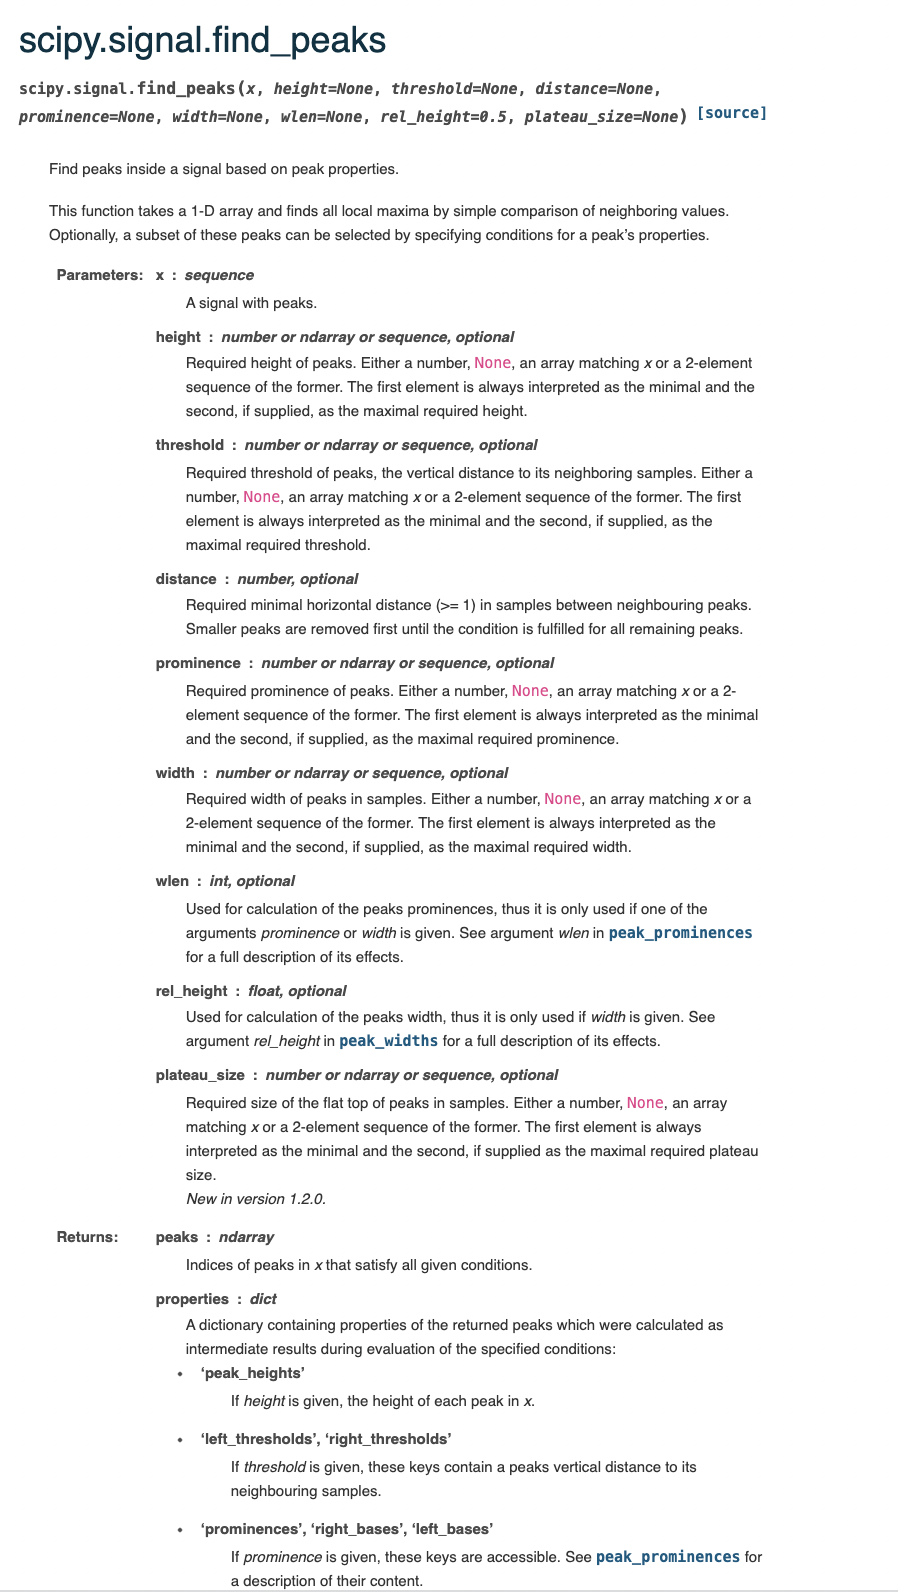

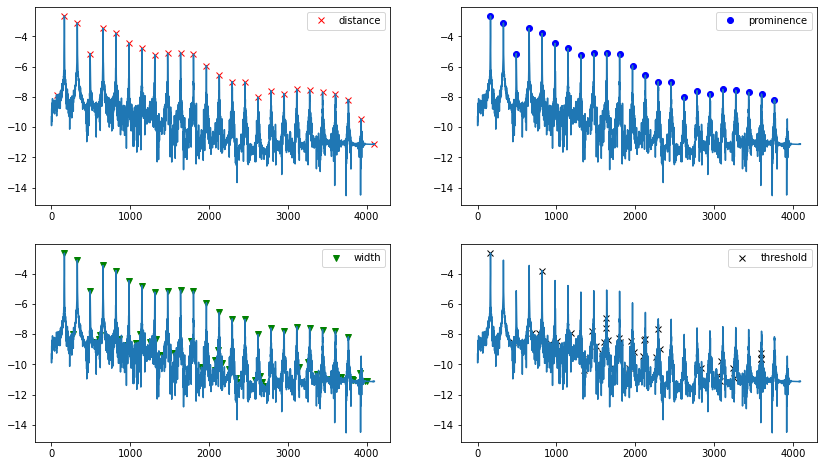

In [22]:
x = logS
peaks, _  = find_peaks(x, distance=100)                  # 100
peaks2, _ = find_peaks(x, prominence=4)      # BEST!     # 4
peaks3, _ = find_peaks(x, width=7)                       # 7
peaks4, _ = find_peaks(x, threshold=1)     # Required vertical distance to its direct neighbouring samples, pretty useless

plt.figure(figsize=(14,8))
plt.subplot(2, 2, 1)
plt.plot(peaks, x[peaks], "xr"); plt.plot(x); plt.legend(['distance'])
plt.subplot(2, 2, 2)
plt.plot(peaks2, x[peaks2], "ob"); plt.plot(x); plt.legend(['prominence'])
plt.subplot(2, 2, 3)
plt.plot(peaks3, x[peaks3], "vg"); plt.plot(x); plt.legend(['width'])
plt.subplot(2, 2, 4)
plt.plot(peaks4, x[peaks4], "xk"); plt.plot(x); plt.legend(['threshold'])
plt.show()

Part of the *art* of audio processing is figuring out the right hyper-parameters for the peaking-picking
algorithm (we will see this throughout the MIR part of the course).  

Two of the most useful are

       distance (what we call `threshold` in HW 02)
       
and 

       prominence: "The prominence of a peak may be defined as the least drop 
       in height necessary in order to get from the summit to any higher terrain." 
             -Wikipedia
       
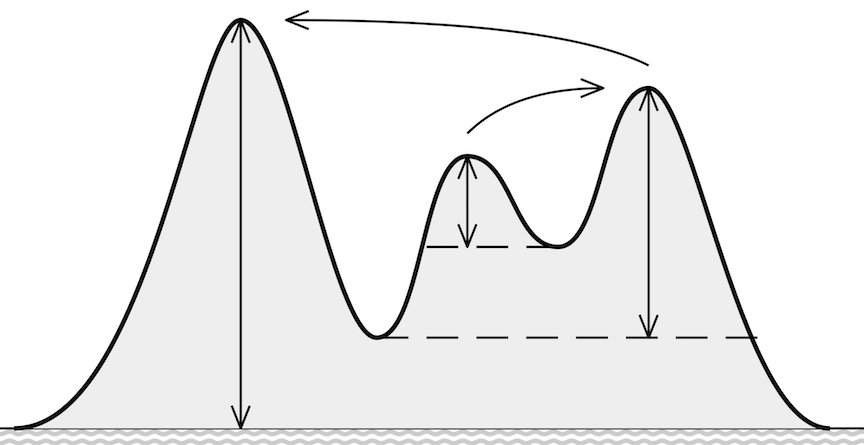

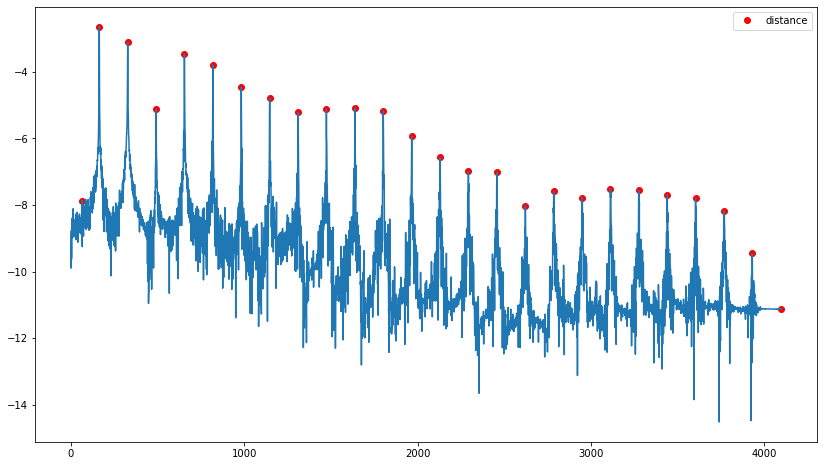

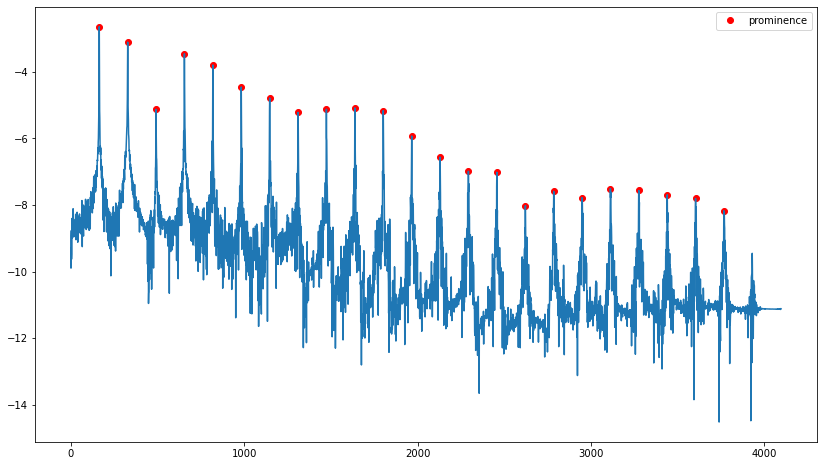

In [23]:

peaks, _ = find_peaks(logS, distance=100)
peaks2, _ = find_peaks(logS, prominence=4)      # BEST!

plt.figure(figsize=(14,8))
plt.plot(peaks, logS[peaks], "or")
plt.plot(logS)
plt.legend(['distance'])
plt.show()

plt.figure(figsize=(14,8))
plt.plot(peaks2, logS[peaks2], "or")
plt.plot(logS)
plt.legend(['prominence'])
plt.show()


BTW:  I have not found the librosa algorithm to be very useful, it is not clear how to set the parameters, but I am willing to be convinced otherwise....

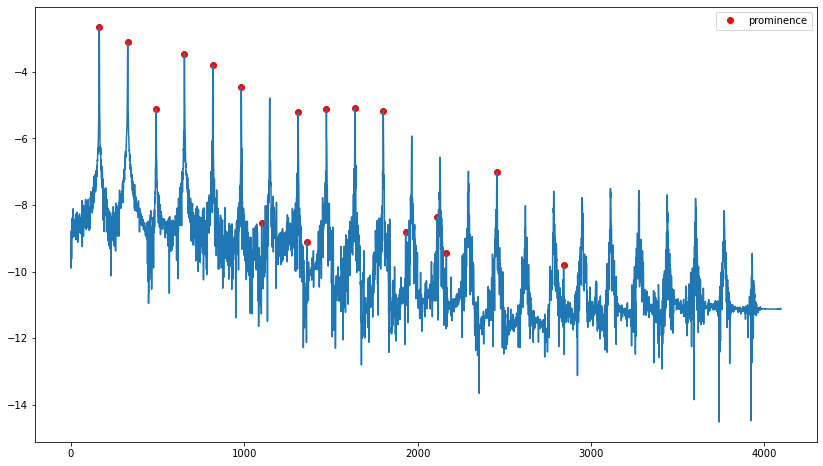

In [24]:
librosa_peaks = librosa.util.peak_pick(logS, 5, 5, 5, 5, 1.2, 50)

#print(librosa_peaks)

plt.figure(figsize=(14,8))
plt.plot(librosa_peaks, logS[librosa_peaks], "or")
plt.plot(logS)
plt.legend(['prominence'])
plt.show()

**Based on my reading of blog posts, and my own experience,  I find the *prominence* parameter to be the most use, and
we will use that in what follows.** 

Now that we have found the peaks, let's turn this back into an magnitude spectrum. 

In [25]:
peaks2

array([ 164,  328,  491,  655,  819,  983, 1147, 1311, 1474, 1638, 1802,
       1966, 2129, 2293, 2457, 2622, 2785, 2948, 3112, 3276, 3440, 3603,
       3766])

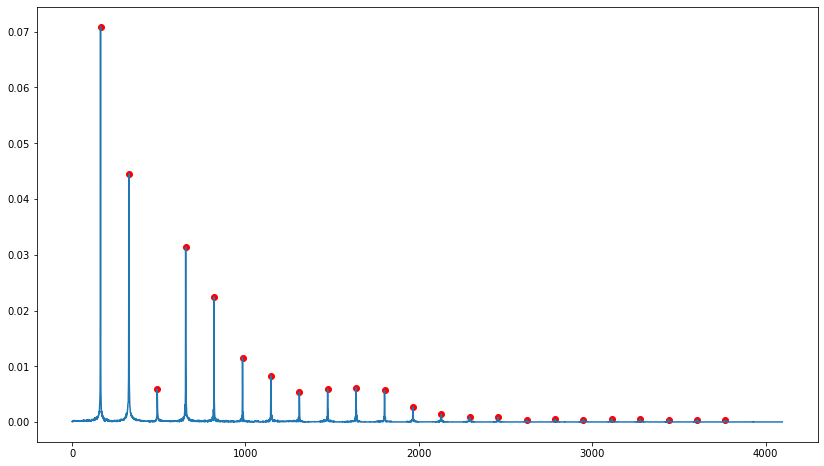

In [26]:
spectrum = np.exp(logS)

plt.figure(figsize=(14,8))
plt.plot(peaks2, S[peaks2], "or")
plt.plot(S)
plt.show()

Now, let's focus on the first peak:

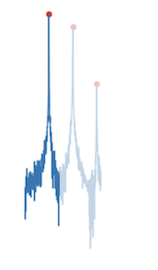

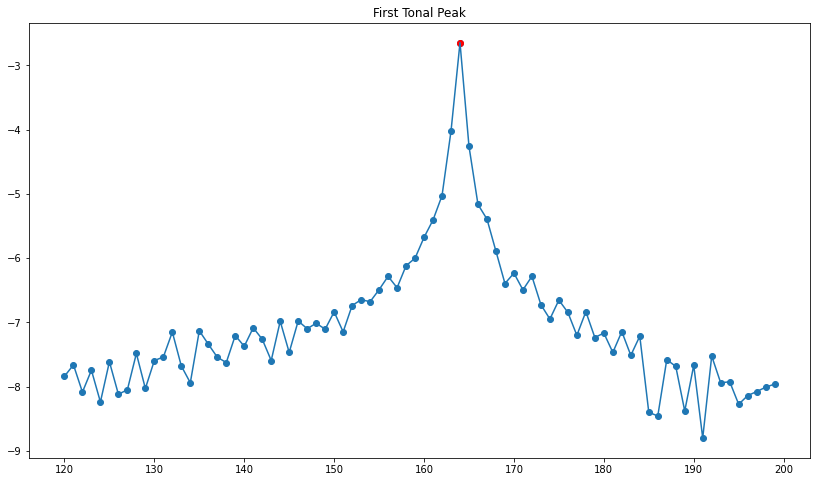

In [27]:
plt.figure(figsize=(14,8))
plt.title("First Tonal Peak")
plt.plot(range(120,200),logS[120:200])
plt.scatter(range(120,200),logS[120:200])
plt.scatter([164],[logS[164]],color='r')
plt.show()

We will use *parabolic interpolation* to find a more accurate estimate of the true peaks, hopefully mitigating some of the problems with lack of frequency resolution. 

In [28]:
# Returns the x coordinate of vertex of parabola defined by points (x1,y1), (x2,yx), (x3,y3)
# http://stackoverflow.com/questions/717762/how-to-calculate-the-vertex-of-a-parabola-given-three-points

#  Ax^2 + Bx + C = y

def parabolicInterpolation(X,Y): 
    [x1,x2,x3] = X
    [y1,y2,y3] = Y
    denom = (x1 - x2) * (x1 - x3) * (x2 - x3);
    A     = (x3 * (y2 - y1) + x2 * (y1 - y3) + x1 * (y3 - y2)) / denom;
    B     = (x3*x3 * (y1 - y2) + x2*x2 * (y3 - y1) + x1*x1 * (y2 - y3)) / denom;
    C     = (x2 * x3 * (x2 - x3) * y1 + x3 * x1 * 
             (x3 - x1) * y2 + x1 * x2 * (x1 - x2) * y3) / denom;

    xv = -B / (2*A);
    yv = C - B*B / (4*A);  
    return (xv,yv,A,B,C)

Let us look a the parabolic calculation to see if it really does find better peaks (if parabolas are
good estimates of spectral peaks). 

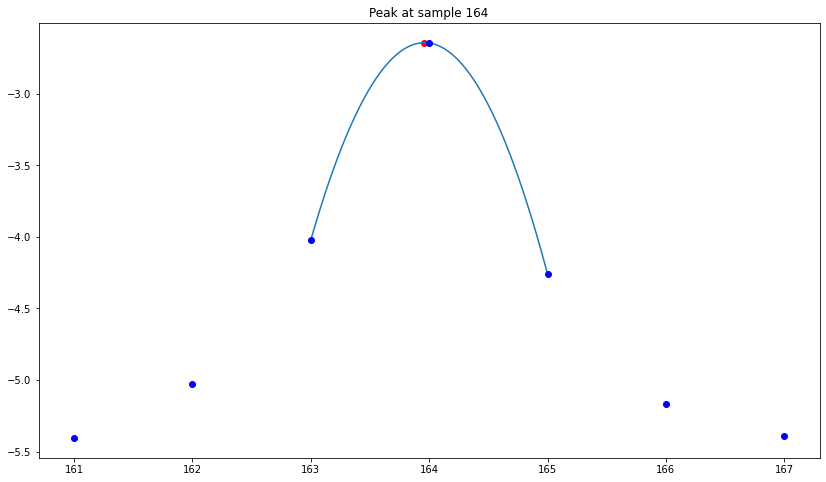

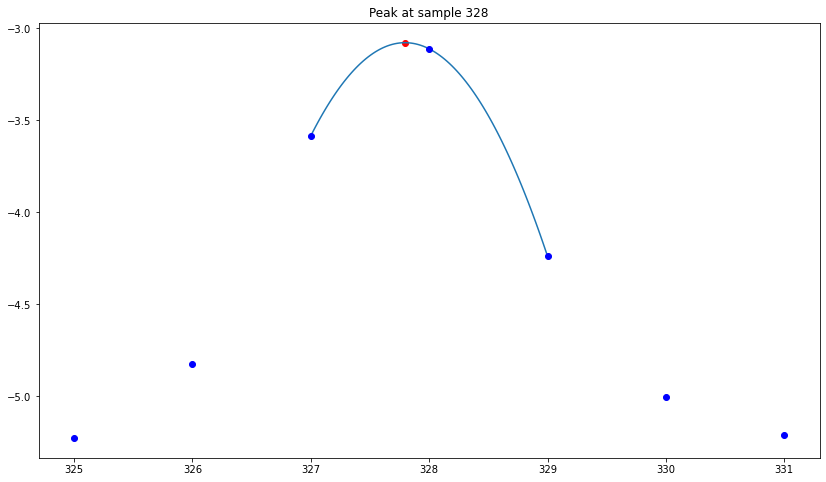

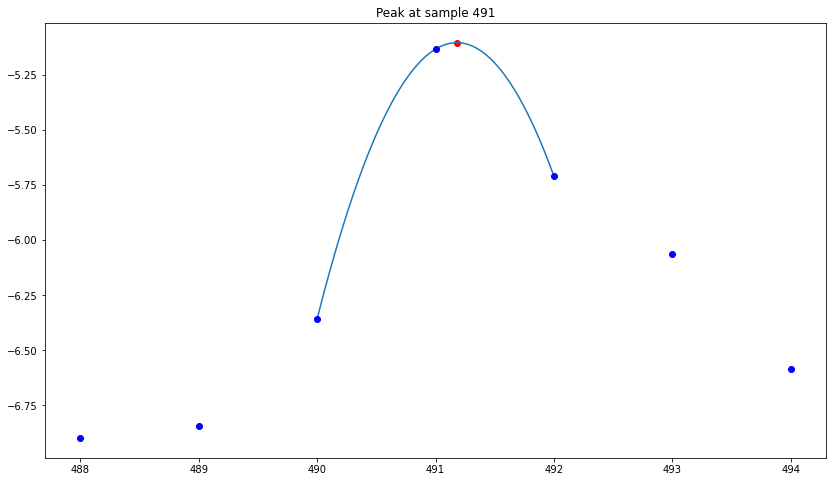

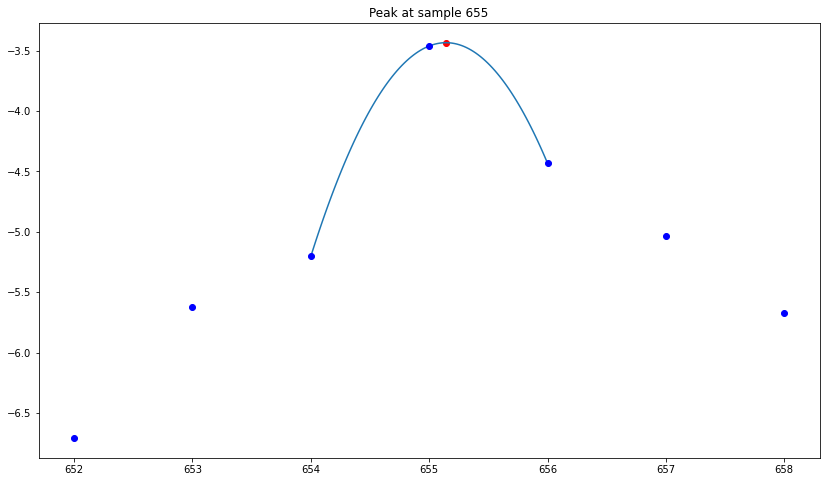

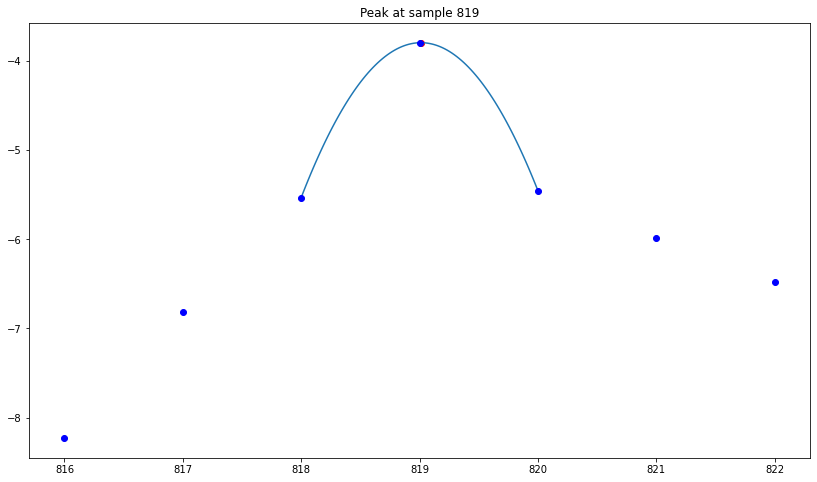

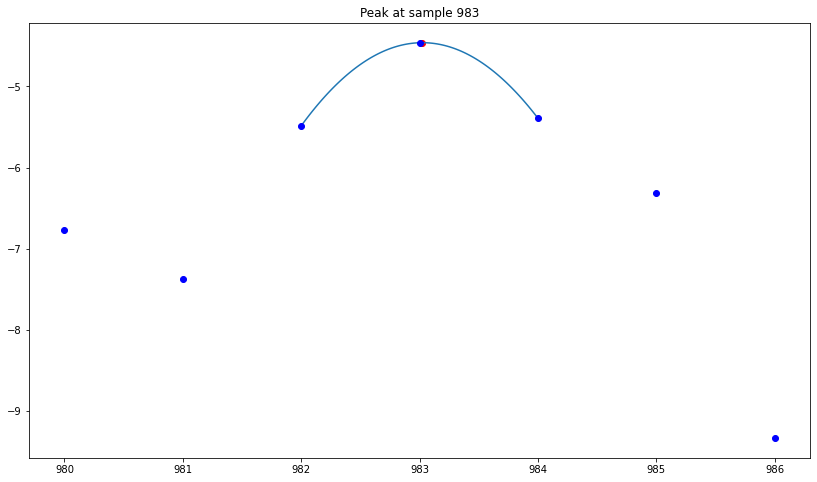

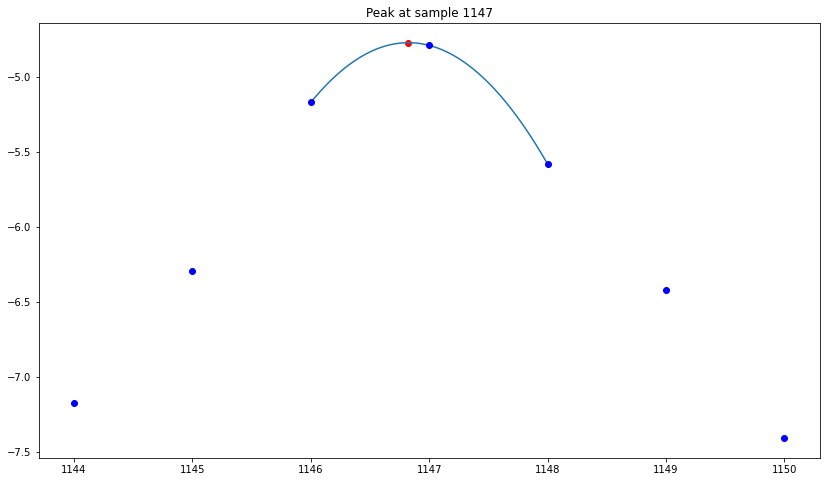

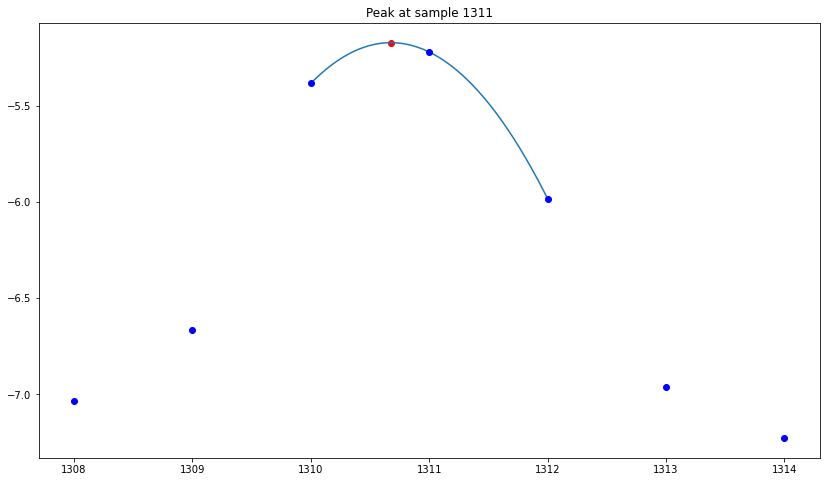

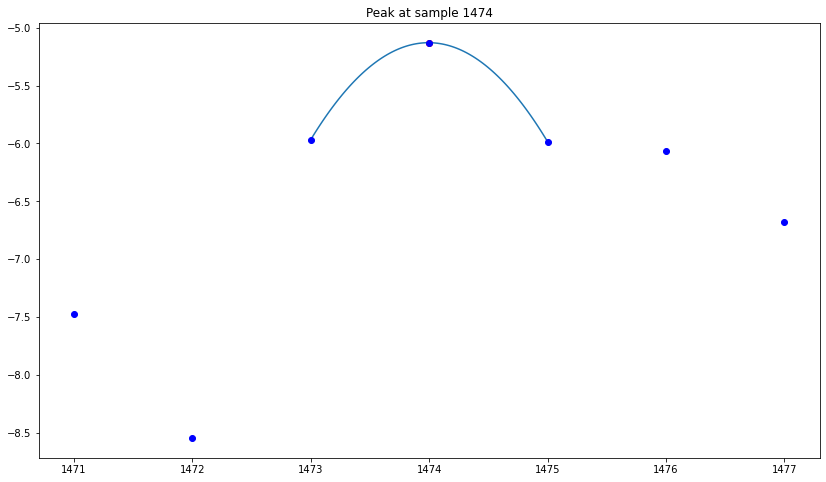

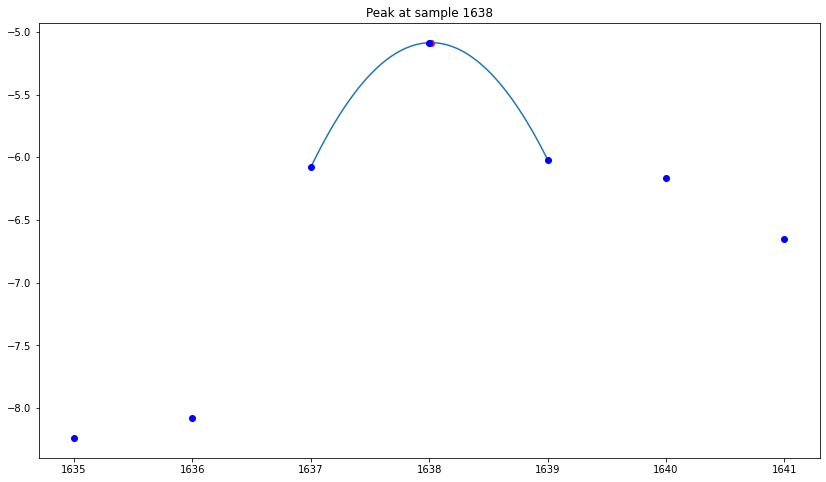

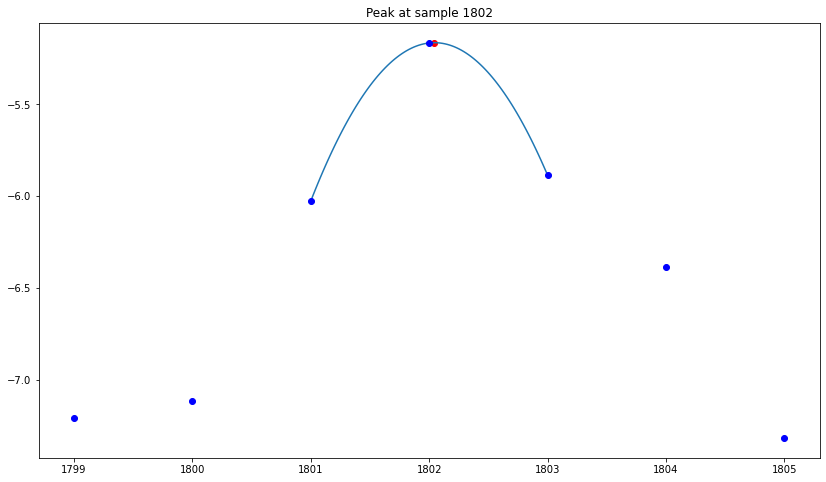

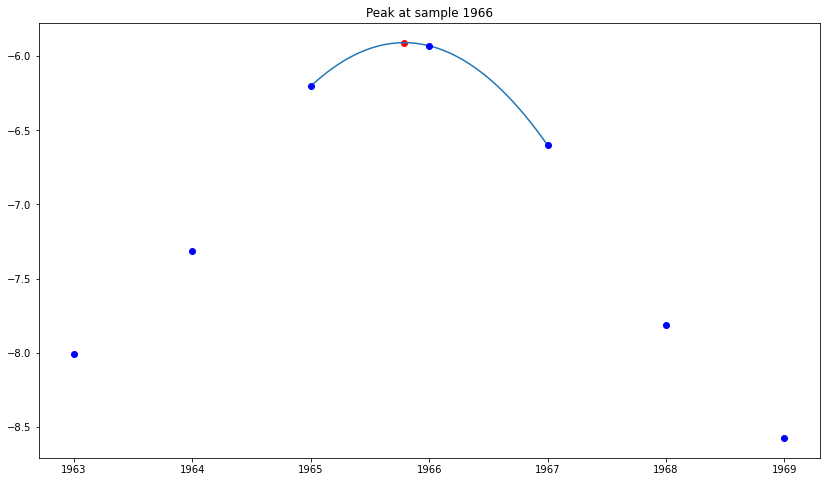

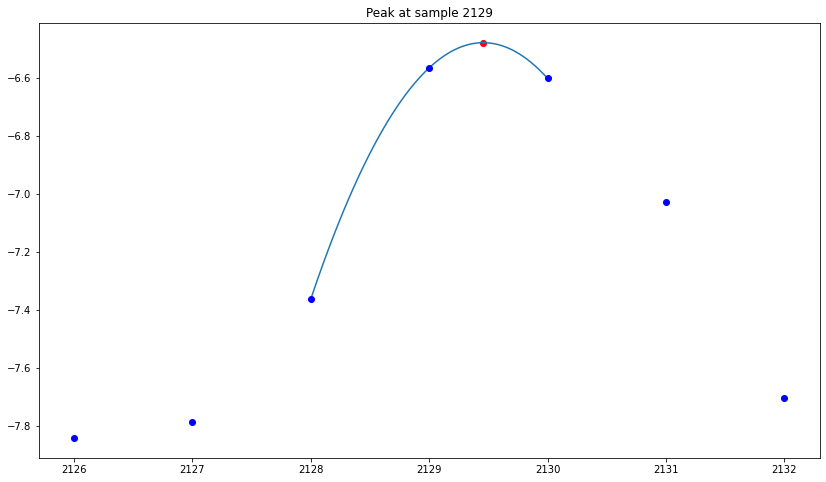

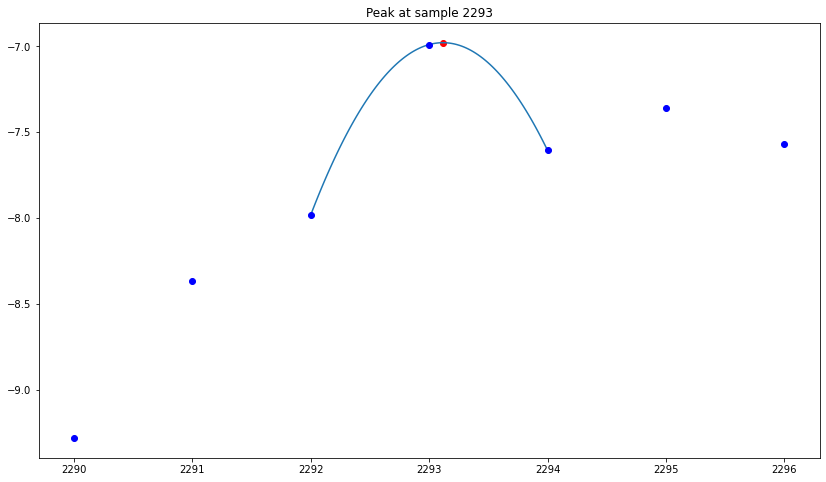

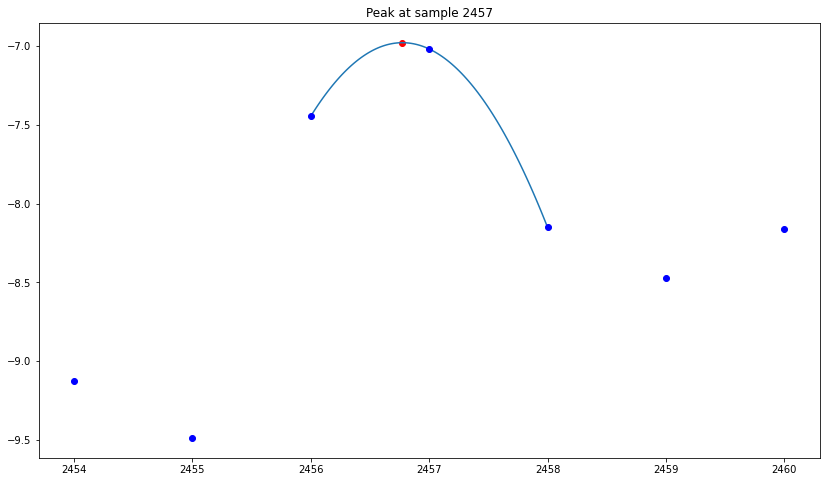

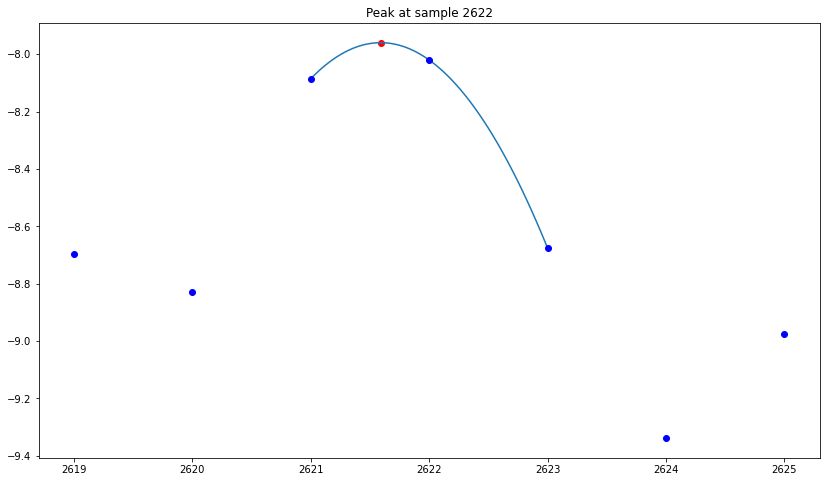

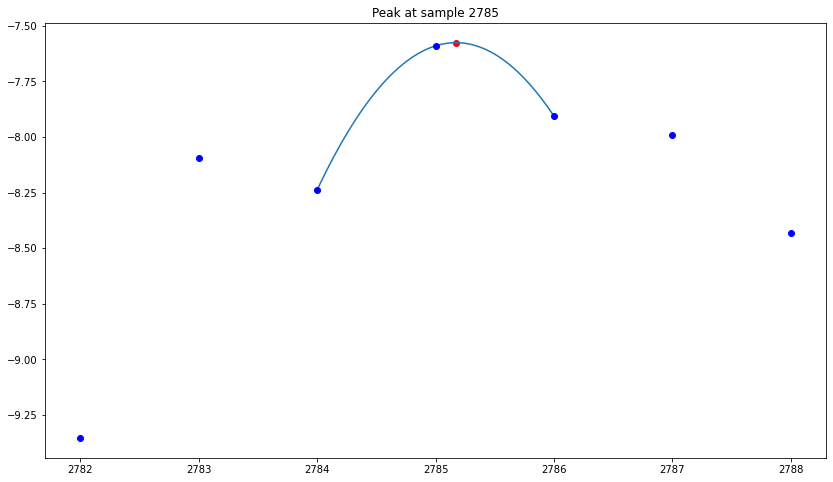

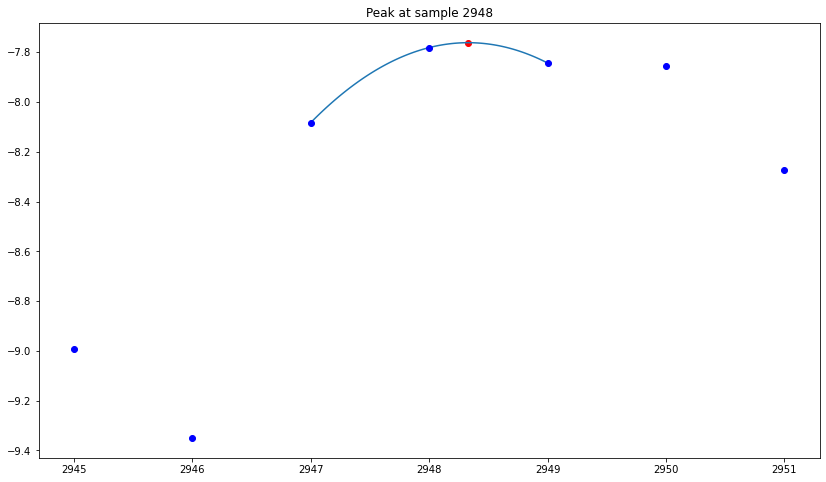

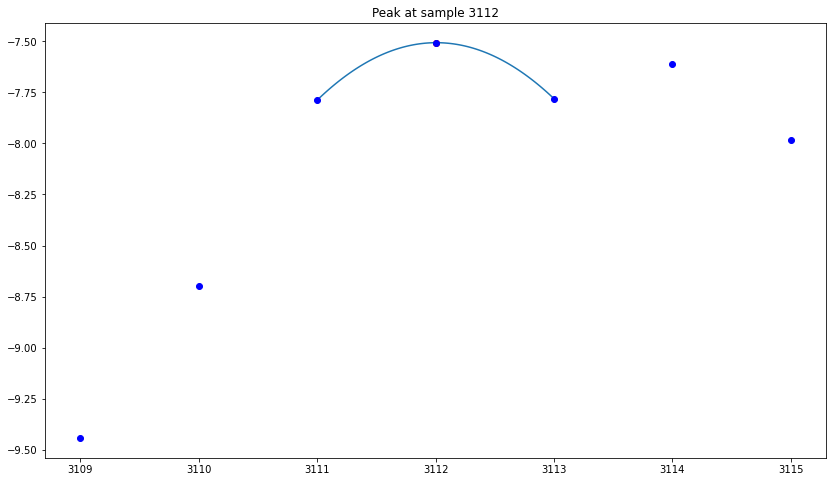

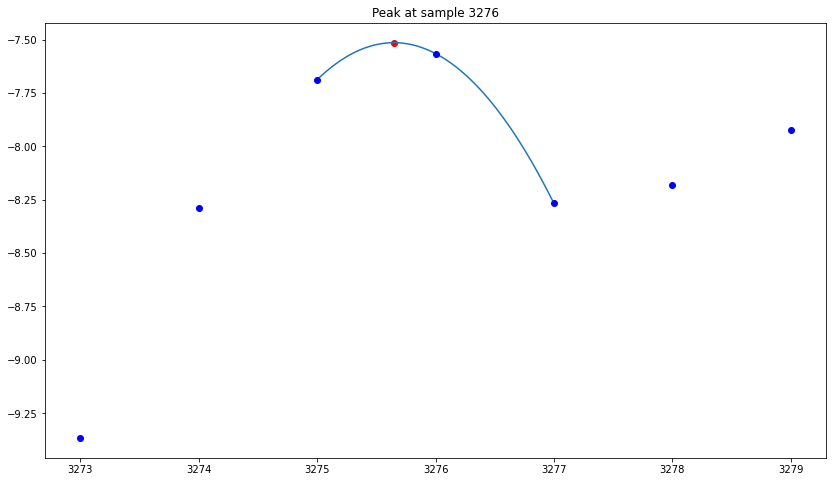

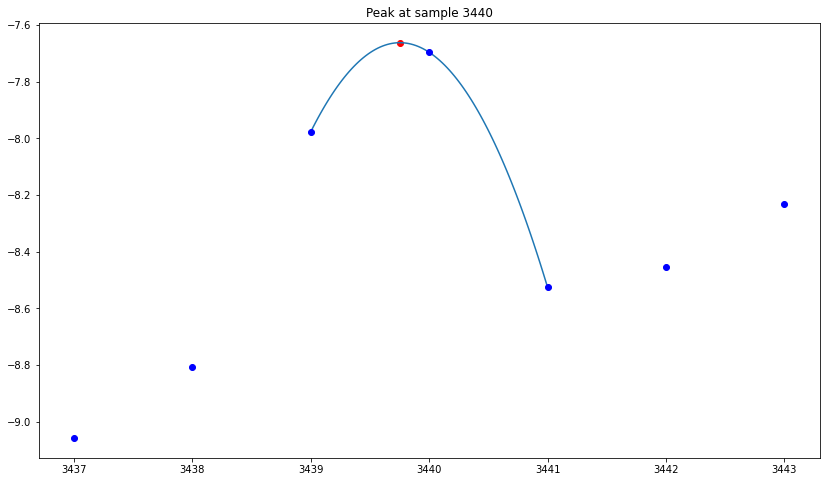

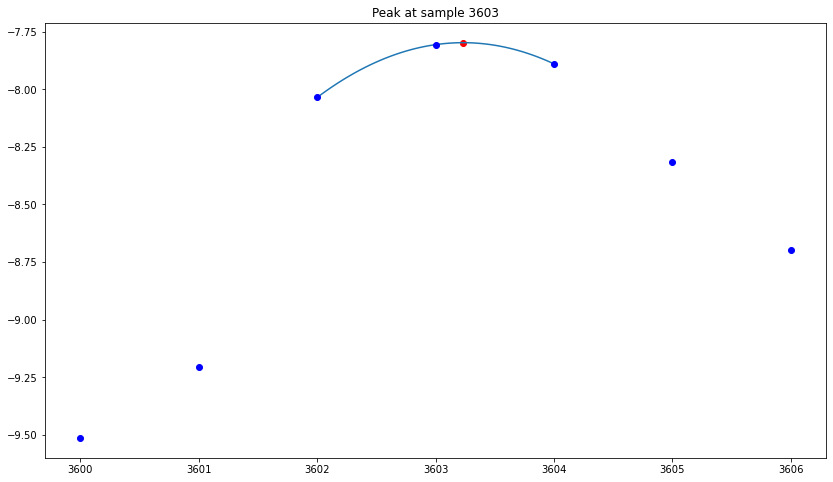

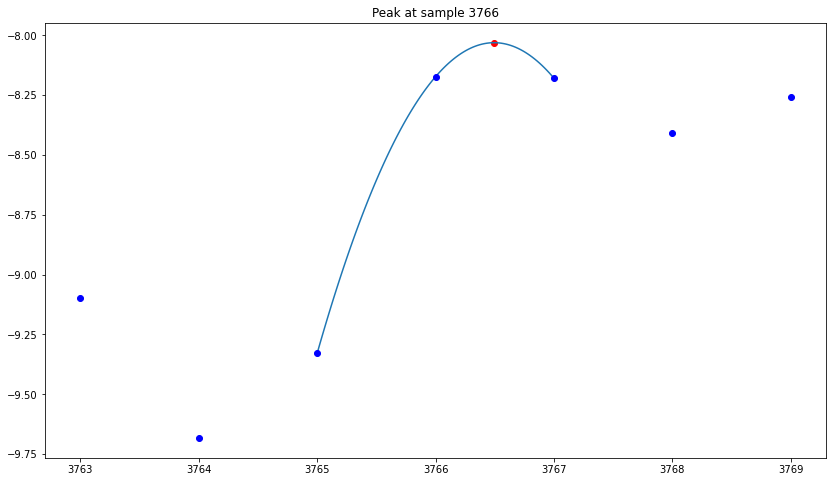

4698.636286678537

In [29]:
# What do the peaks look like?

log_spectrum = []

for n in range(len(peaks2)):
    k = peaks2[n]
    #print(k)

    x_vals = [k-3,k-2,k-1,k,k+1,k+2,k+3]
    y_vals = [ logS[v] for v in x_vals]
    
    #print(x_vals)
    #print(y_vals,"\n")

    (xv,yv,A,B,C) = parabolicInterpolation(x_vals[2:5],y_vals[2:5])
    log_spectrum.append((xv,yv))
    
    X = np.linspace(k-1,k+1,100)
    Y = [ A*x**2 + B * x + C for x in X]

    #print((xv,yv))

    plt.figure(figsize=(14,8))
    plt.title("Peak at sample " + str(k))
    plt.plot(X,Y)
    plt.plot(x_vals, y_vals, "ob")
    plt.scatter([xv],[yv],color="r")
    plt.show()
f

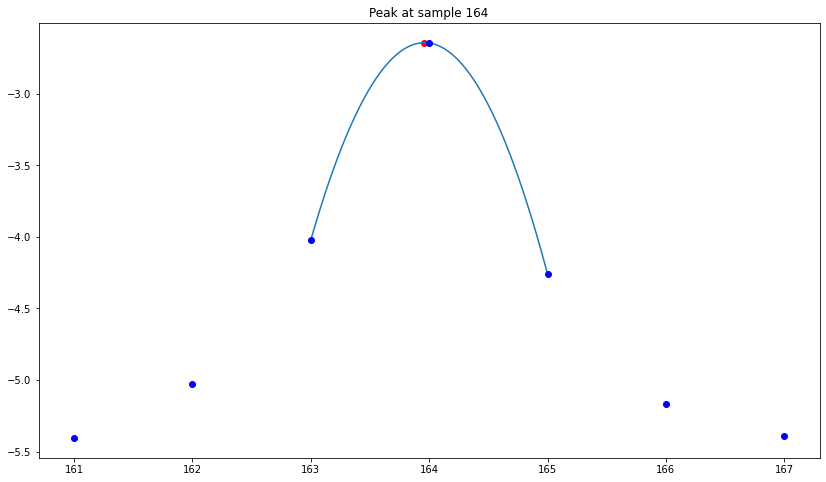

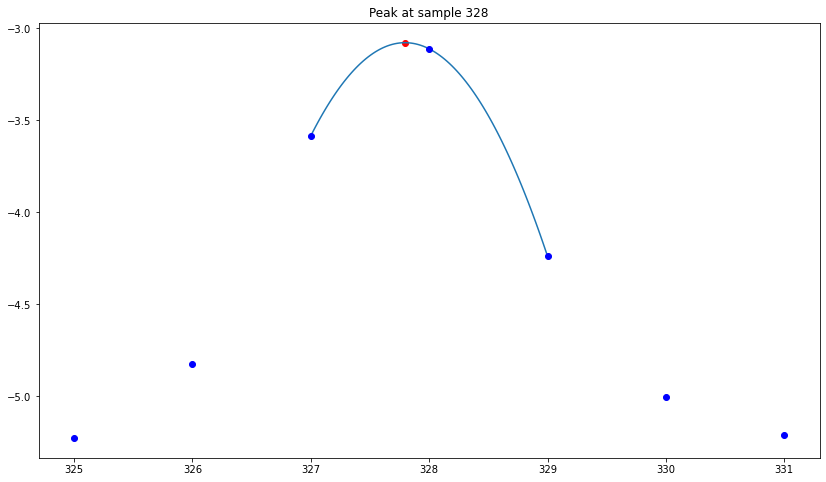

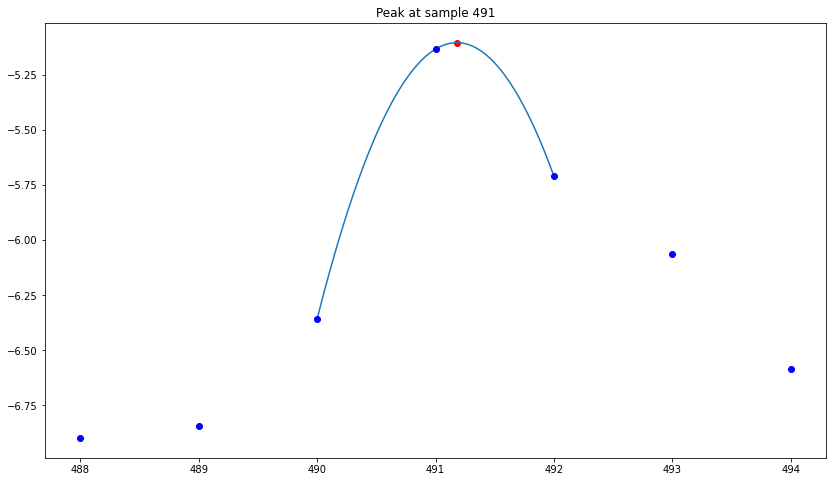

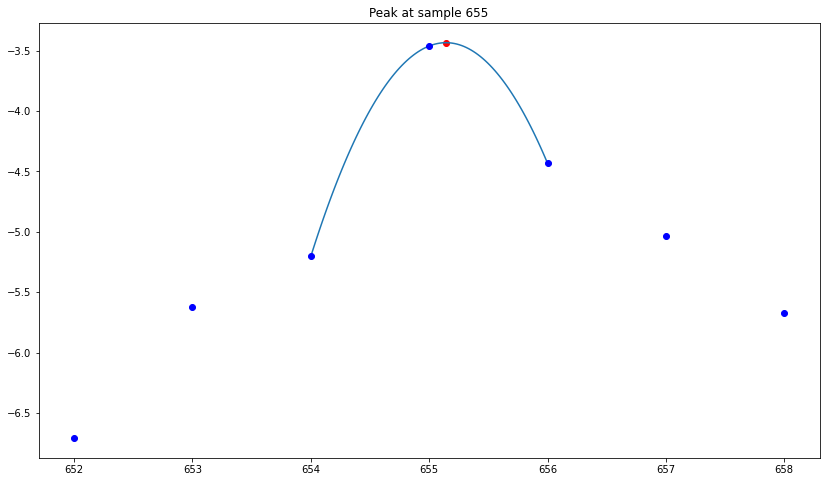

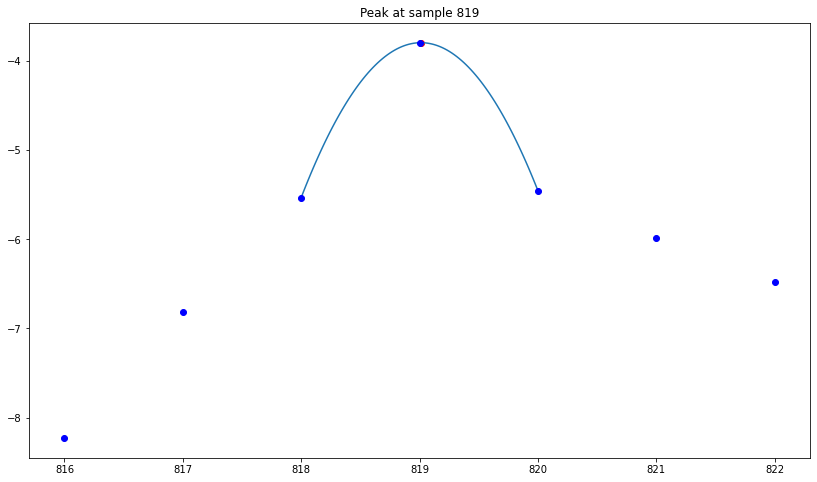

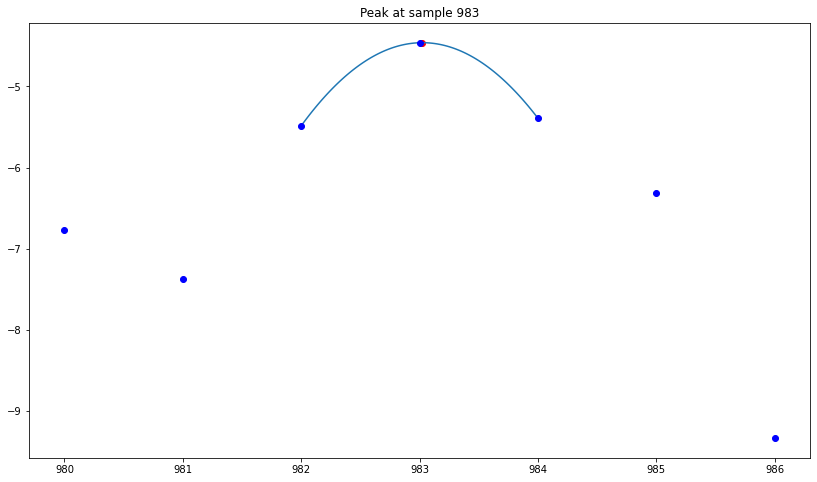

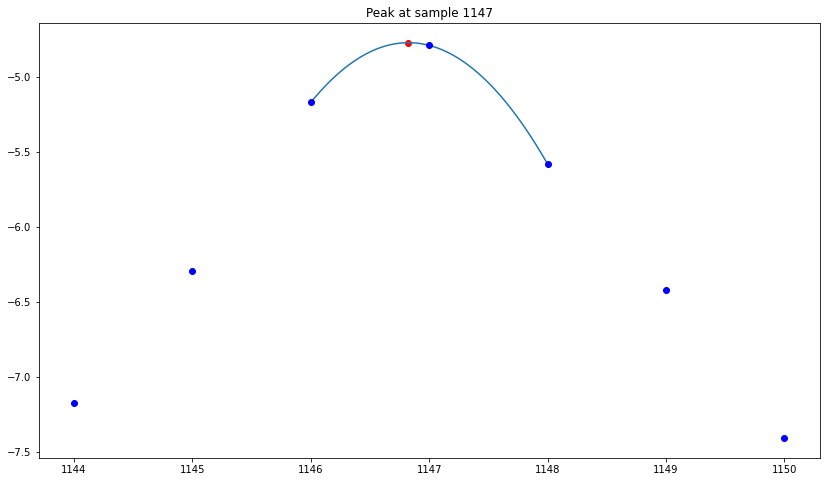

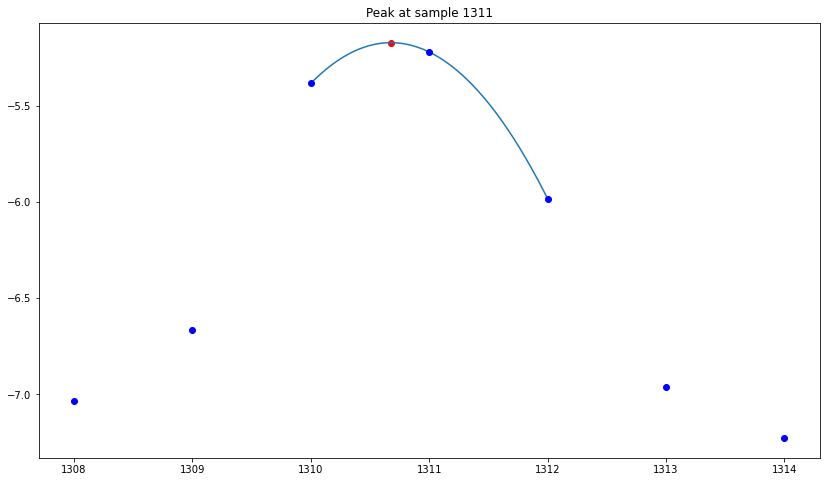

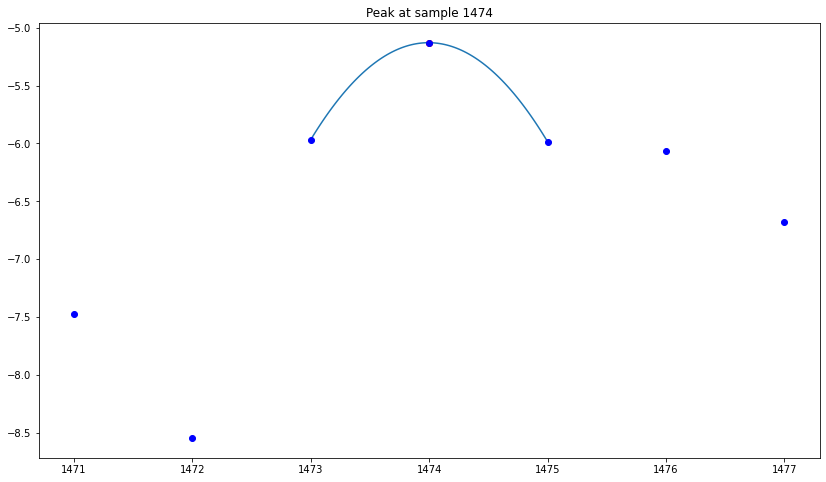

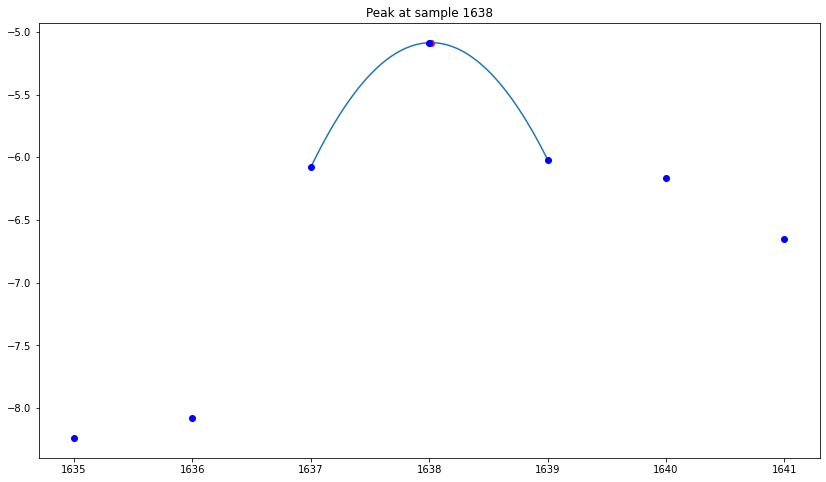

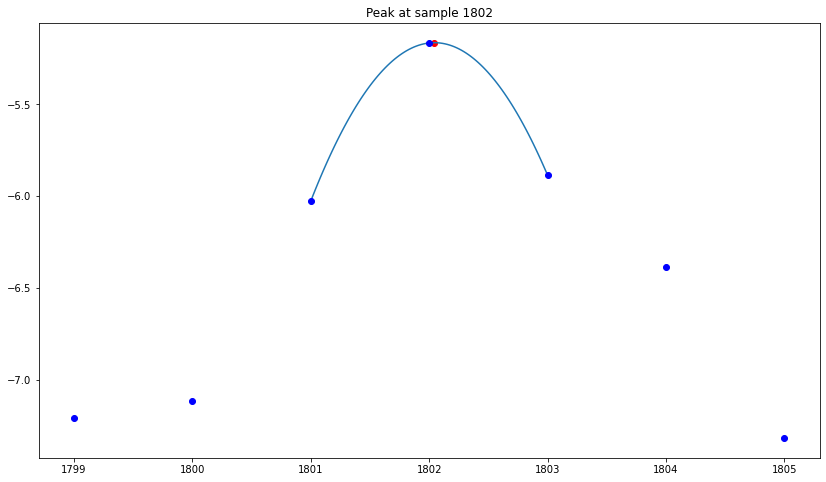

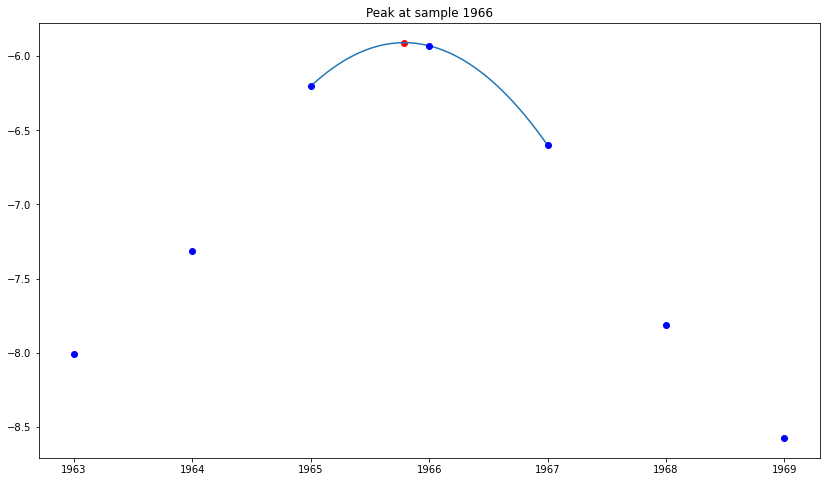

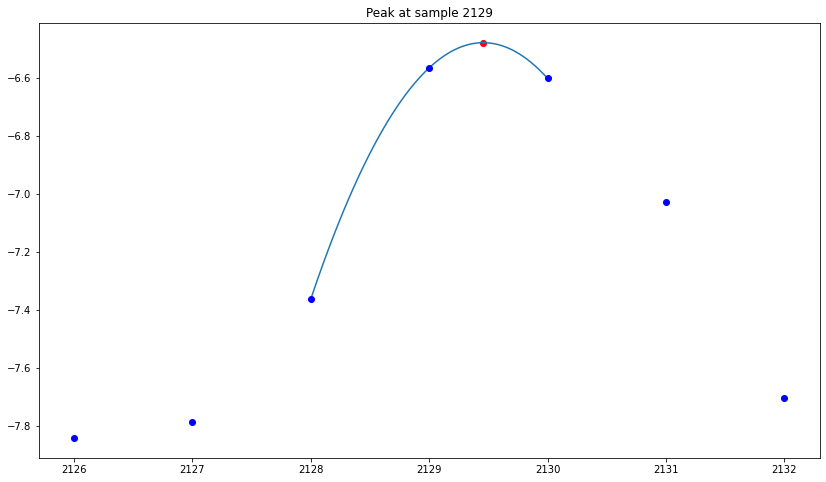

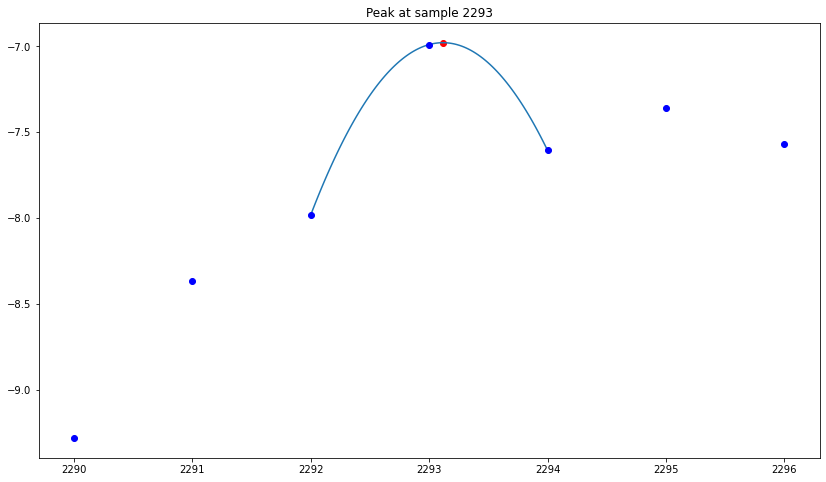

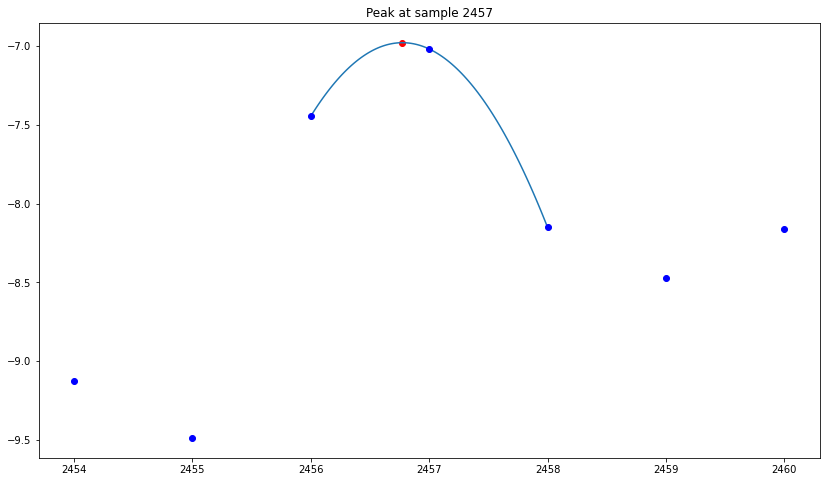

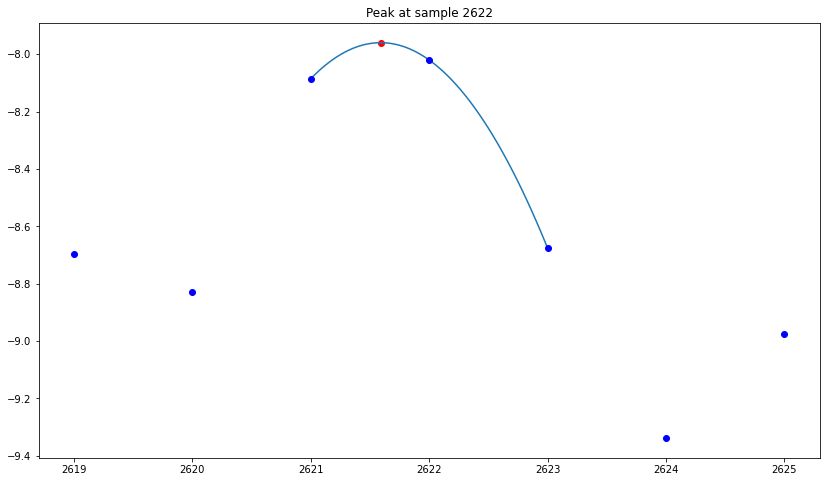

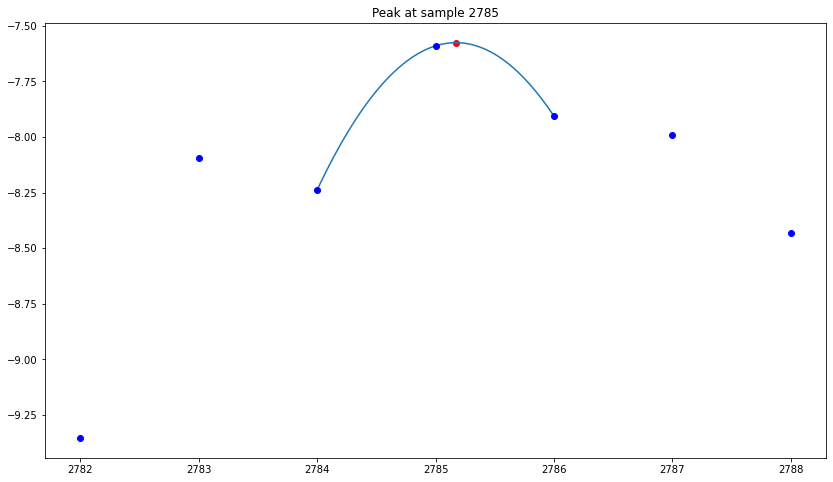

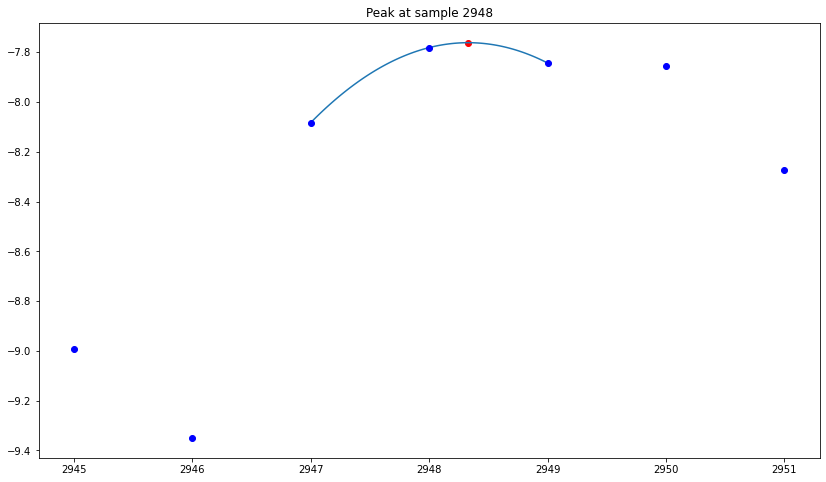

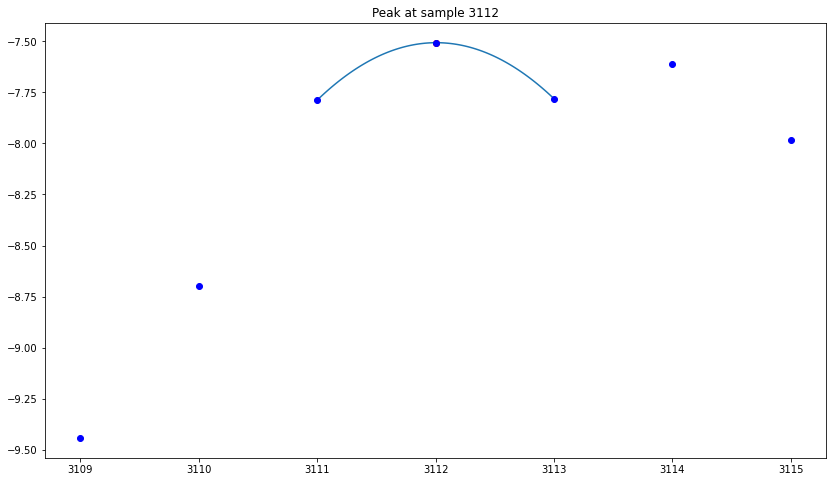

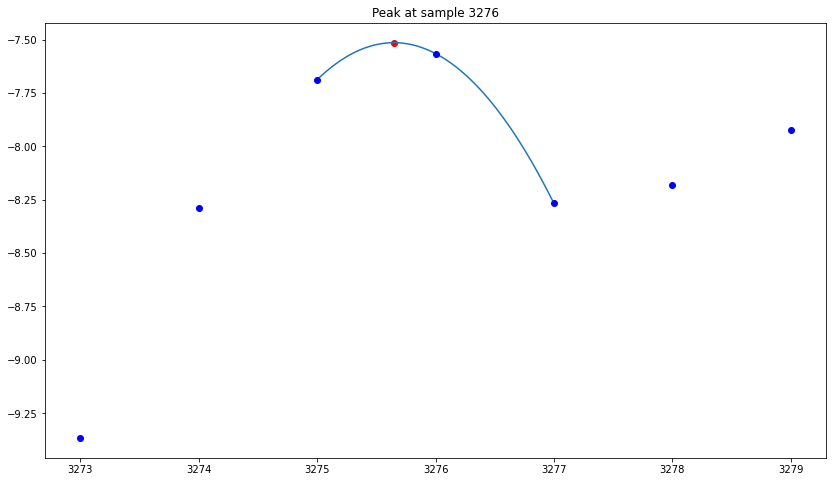

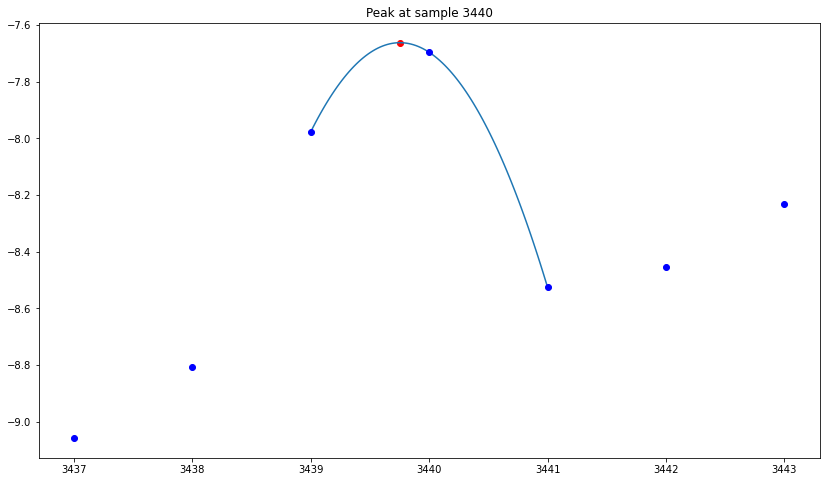

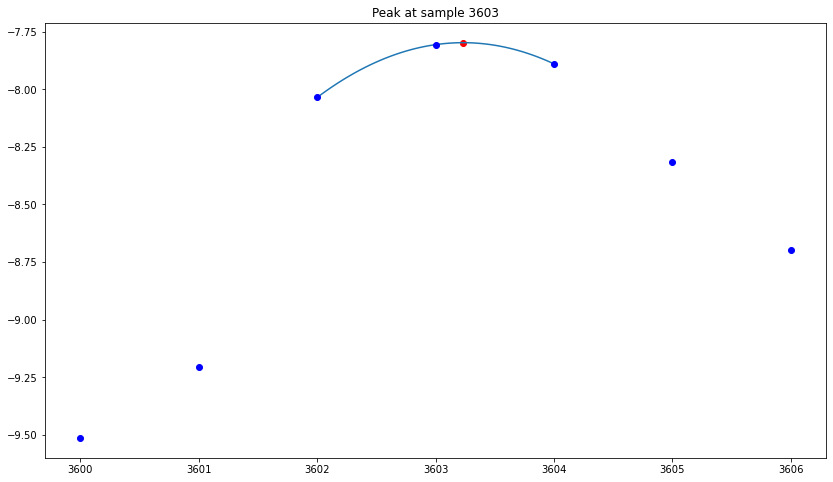

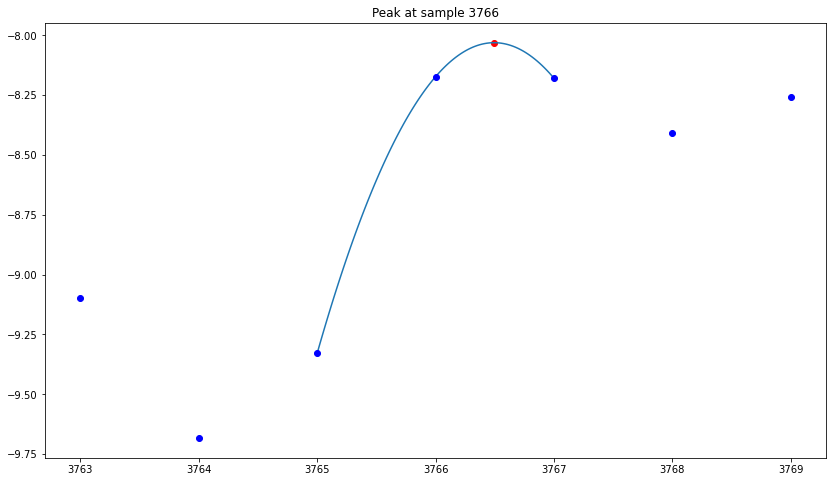

In [30]:
# What do the peaks look like?

log_spectrum = []

for n in range(len(peaks2)):
    k = peaks2[n]
    #print(k)

    x_vals = [k-3,k-2,k-1,k,k+1,k+2,k+3]
    y_vals = [ logS[v] for v in x_vals]
    
    #print(x_vals)
    #print(y_vals,"\n")

    (xv,yv,A,B,C) = parabolicInterpolation(x_vals[2:5],y_vals[2:5])
    log_spectrum.append((xv,yv))
    
    X = np.linspace(k-1,k+1,100)
    Y = [ A*x**2 + B * x + C for x in X]

    #print((xv,yv))

    plt.figure(figsize=(14,8))
    plt.title("Peak at sample " + str(k))
    plt.plot(X,Y)
    plt.plot(x_vals, y_vals, "ob")
    plt.scatter([xv],[yv],color="r")
    plt.show()


### Isolating the tonal elements of the spectrum

If we extract the peaks from the whole spectrum, then we have (hopefully) isolated
the tonal elements of the spectrum!

In [31]:
spectrum = np.array( [(window_freq*x,np.exp(y),0) for (x,y) in log_spectrum] )

X = np.array( [window_freq*x for (x,y) in log_spectrum] )
Y = np.array( [np.exp(y) for (x,y) in log_spectrum] )

In [32]:
print("Here is the refined spectrum using parabolic interpolation:\n")
print(spectrum)

Here is the refined spectrum using parabolic interpolation:

[[4.41323456e+02 7.10677669e-02 0.00000000e+00]
 [8.82310600e+02 4.60258341e-02 0.00000000e+00]
 [1.32208417e+03 6.07383523e-03 0.00000000e+00]
 [1.76341362e+03 3.22284067e-02 0.00000000e+00]
 [2.20449246e+03 2.24313840e-02 0.00000000e+00]
 [2.64595719e+03 1.15666418e-02 0.00000000e+00]
 [3.08685108e+03 8.45534916e-03 0.00000000e+00]
 [3.52788234e+03 5.67121962e-03 0.00000000e+00]
 [3.96747830e+03 5.92532370e-03 0.00000000e+00]
 [4.40896632e+03 6.18073382e-03 0.00000000e+00]
 [4.85047397e+03 5.71217909e-03 0.00000000e+00]
 [5.29121649e+03 2.71298205e-03 0.00000000e+00]
 [5.73175265e+03 1.53675603e-03 0.00000000e+00]
 [6.17226840e+03 9.31462785e-04 0.00000000e+00]
 [6.61277545e+03 9.31585999e-04 0.00000000e+00]
 [7.05640432e+03 3.49123383e-04 0.00000000e+00]
 [7.49670992e+03 5.12581863e-04 0.00000000e+00]
 [7.93587268e+03 4.25717287e-04 0.00000000e+00]
 [8.37643364e+03 5.49224052e-04 0.00000000e+00]
 [8.81689944e+03 5.45196533

### Calculate the frequencies (x axis) and amplitudes (y axis) from the spectrum

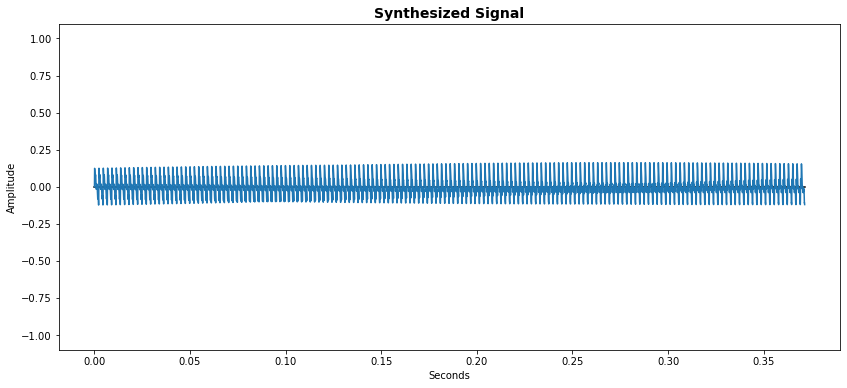

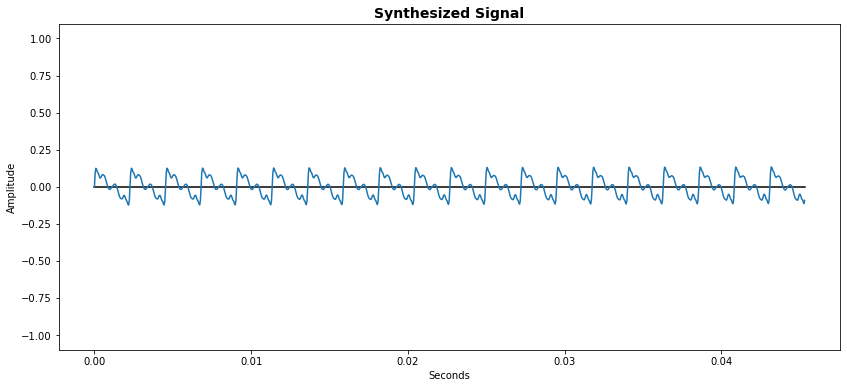

In [33]:
X_synthesized = makeSignal(spectrum,duration=0.3715)


displaySignal(X_synthesized,title="Synthesized Signal")

displaySignal(X_synthesized[:1000],title="Synthesized Signal")

Audio(X_synthesized,rate=SR)

**Here is the original, real signal.**

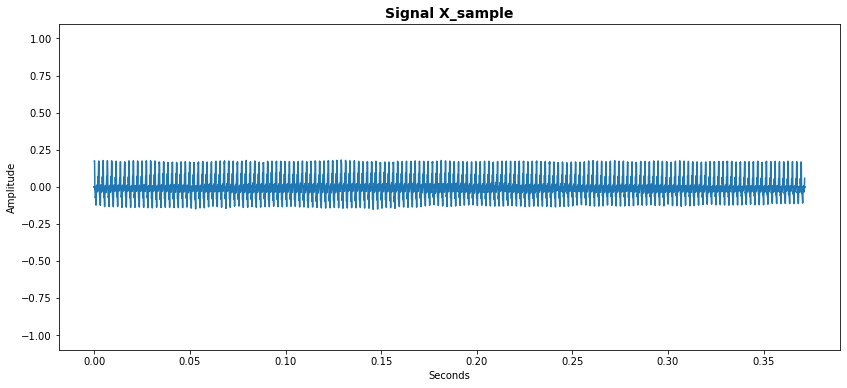

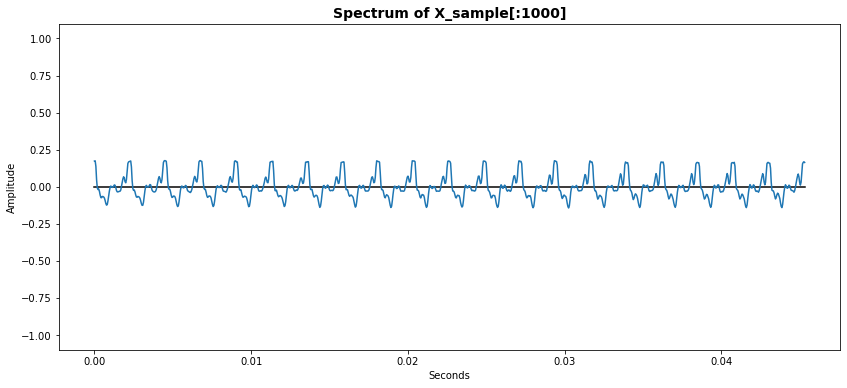

In [34]:
displaySignal(X_sample,title='Signal X_sample')

displaySignal(X_sample[:1000],title='Spectrum of X_sample[:1000]')

Audio(X_sample,rate=SR)

## Synthesizing the Clarinet Signal

The clarinet signal has a 1.0 second sample, which is useful, let's try that....

In [35]:
def getSpectrum(X,prominence=4):
    S = realFFT(X)
    logS = np.log(S)
    peaks, _ = find_peaks(logS, prominence=prominence)   
    log_spectrum = []

    for p in peaks:
        #print(p)
        x_vals = [p-1,p,p+1]
        y_vals = [ logS[x] for x in x_vals]
        (xv,yv,_,_,_) = parabolicInterpolation(x_vals,y_vals)
        log_spectrum.append((xv,yv))

    window_freq = SR/len(X)

    return np.array( [(window_freq*x,np.exp(y),0) for (x,y) in log_spectrum] )

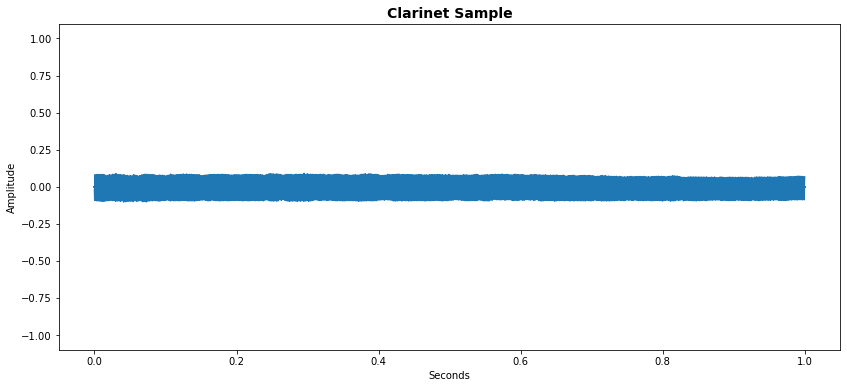

In [36]:
X = X_clarinet[int(0.25*SR):int(1.25*SR)]
displaySignal(X,title="Clarinet Sample")

[[4.41288796e+02 4.99883631e-02 0.00000000e+00]
 [8.82901862e+02 1.93114601e-02 0.00000000e+00]
 [1.32426852e+03 2.69294831e-02 0.00000000e+00]
 [1.76547550e+03 1.14668350e-02 0.00000000e+00]
 [2.20653937e+03 5.37779845e-03 0.00000000e+00]
 [2.64815446e+03 5.17351673e-03 0.00000000e+00]
 [3.08874217e+03 2.03239728e-03 0.00000000e+00]
 [3.37691008e+03 5.35024288e-05 0.00000000e+00]
 [3.53019056e+03 8.66593576e-04 0.00000000e+00]
 [3.97270638e+03 1.31406091e-03 0.00000000e+00]
 [4.41412327e+03 7.33143806e-04 0.00000000e+00]
 [4.79320063e+03 5.33493622e-05 0.00000000e+00]
 [4.85357865e+03 3.64756699e-04 0.00000000e+00]
 [5.29437741e+03 1.98022998e-04 0.00000000e+00]
 [5.73909698e+03 2.58778105e-04 0.00000000e+00]
 [6.18020263e+03 8.79818923e-05 0.00000000e+00]
 [6.62032103e+03 6.27712192e-05 0.00000000e+00]
 [7.50402210e+03 7.15195535e-05 0.00000000e+00]]


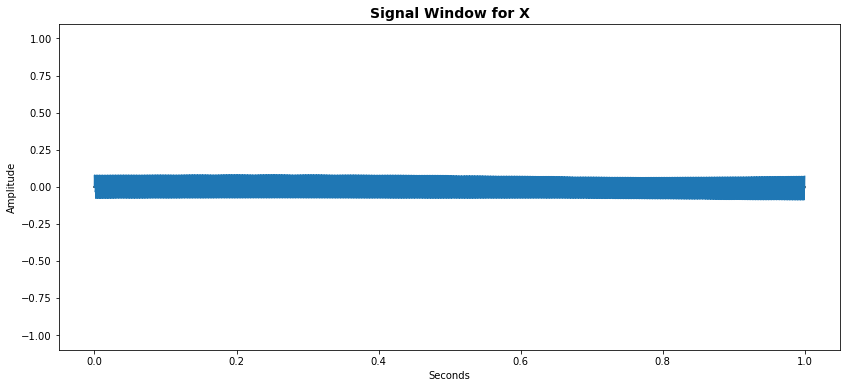

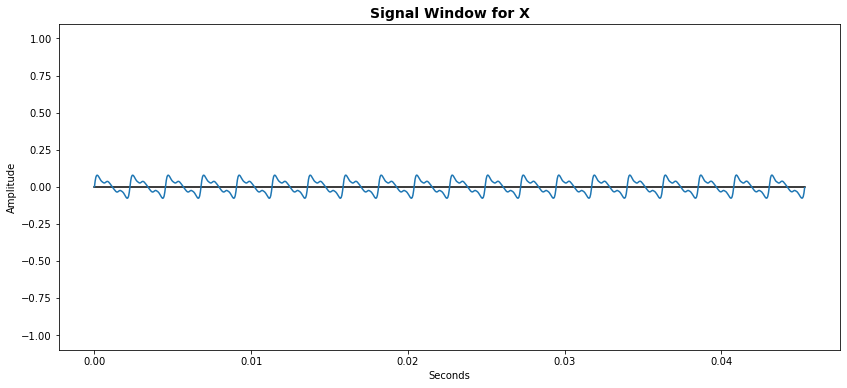

In [37]:
S = getSpectrum(X)

print(S)

X1 = makeSignal(S,duration=len(X)/SR)

displaySignal(X1)

displaySignal(X1[:1000])

Audio(X1,rate=SR)

We could try to get the actual phases if we want....

In [38]:
   
def spectrumFFT(X,filterZeros=True):
    R =  np.fft.rfft(X)
    if(filterZeros):
        return np.array([ ( k*SR/len(X), 2.0 * np.absolute(R[k])/len(X),np.angle(R[k])+(np.pi/2) ) 
                            for k in range(len(R)) 
                                if not np.isclose(2.0 * np.absolute(R[k])/len(X),0.0) ]) 
    else:
        return np.array([ ( k*SR/len(X), 2.0 * np.absolute(R[k])/len(X),np.angle(R[k])+(np.pi/2) ) 
                            for k in range(len(R)) ]) 


    
S1 = spectrumFFT(X)
S1

array([[ 0.00000000e+00,  1.13680012e-05,  4.71238898e+00],
       [ 1.00000000e+00,  9.40285005e-06,  4.66385458e+00],
       [ 2.00000000e+00,  1.12767741e-05, -1.27958743e+00],
       ...,
       [ 1.10230000e+04,  3.84225763e-06,  4.71031751e+00],
       [ 1.10240000e+04,  3.84212020e-06,  4.71141360e+00],
       [ 1.10250000e+04,  3.85664686e-06,  4.71238898e+00]])

We can now retrofit the phases from the real clarinet signal into the synthesized spectrum:

In [39]:
S2 = []

F = [round(f) for (f,A,phi) in S]

for (f,A,phi) in S:
    phi2 = S1[round(f)][2]
    S2.append((f,A,phi2))

S2

[(441.28879555995013, 0.04998836313404823, 0.039543968107336847),
 (882.90186159274, 0.019311460122644543, 2.6348343716531106),
 (1324.2685188000169, 0.026929483141549346, 2.709040256853433),
 (1765.4755035389683, 0.011466834953944094, 4.29780708487846),
 (2206.539372287423, 0.005377798451241438, 0.5638696526653741),
 (2648.154462216382, 0.0051735167299893576, -1.0187487424310162),
 (3088.7421746346763, 0.0020323972828004523, 0.8056527066626462),
 (3376.9100836894218, 5.350242881168098e-05, -0.24395815516703),
 (3530.1905573055274, 0.0008665935760927936, 1.599375127461917),
 (3972.706376491895, 0.0013140609060066778, -1.4631926737093734),
 (4414.1232704649465, 0.0007331438059833234, 2.3802543586127762),
 (4793.200626218142, 5.334936219950969e-05, 3.8434869373819502),
 (4853.578645901004, 0.00036475669885363337, -0.4175317447753135),
 (5294.3774076864, 0.00019802299821494946, 3.3705016465840996),
 (5739.096981376248, 0.0002587781046380697, 1.1879351789643664),
 (6180.202628814331, 8.798

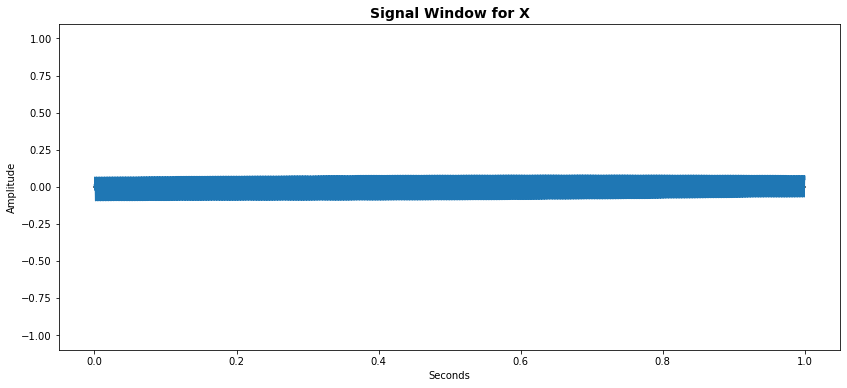

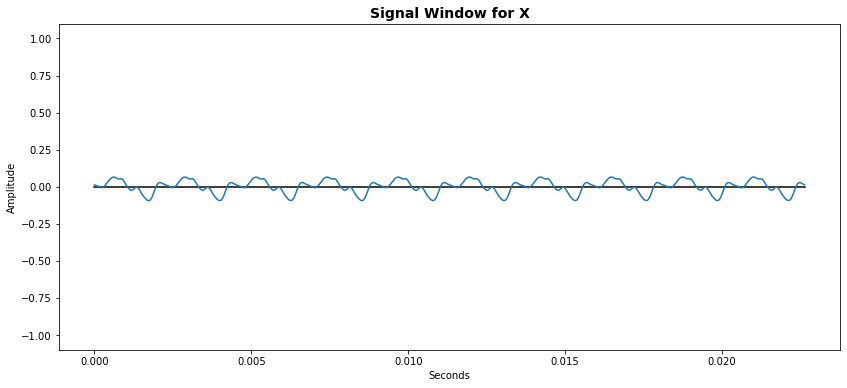

In [40]:
X3 = makeSignal(S2,duration=len(X)/SR)

displaySignal(X3)

displaySignal(X3[:500])

Audio(X3,rate=SR)